<!-- # Notebook for Simulating $\hat c_j^i$ Distribution -->

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex

from numpy import linalg as LA

## Configuration

### $X^i$ ~ $N(0, I_d)$
### $w^i$ ~ $U[-10, 10]$

Creating the toy dataset with n = 200, $m_i$ = 10, and d = 10.

In [2]:
NUM_SAMPLES = 10
NUM_CLIENTS = 50
NUM_CLUSTERS = 2

## Creating Dataset

In [232]:
def get_data(num_features, num_clusters=NUM_CLUSTERS, num_clients=NUM_CLIENTS, num_training_samples=NUM_SAMPLES, noise=0.0):
    w = np.random.uniform(-5,5,(num_clusters,num_features)) # here we shape all w for all clients
    clusters = []

    X = np.zeros ((num_clusters,num_clients,num_training_samples,num_features)) 
    y = np.zeros ((num_clusters,num_clients,num_training_samples))
    localdatasets = np.zeros((num_clusters,num_clients,num_training_samples,(num_features+1)))
    clusterassgts = np.zeros((num_clusters,num_clients,num_training_samples))
    for iter_cluster in range(num_clusters): 
        for iter_node in range(0, num_clients):
            X[iter_cluster, iter_node,:,:] = np.random.randn(num_training_samples, num_features)
            r = X[iter_cluster, iter_node,:,:] @ w[iter_cluster, :].reshape(-1, 1) + np.random.normal(loc=0.0, scale=noise, size=(NUM_SAMPLES, 1))
            y[iter_cluster, iter_node,:] = r.squeeze()
            clusters.append(iter_cluster)
            for iter_sample in range(0,num_training_samples): 
                localdatasets[iter_cluster,iter_node,iter_sample,:] = np.hstack((X[iter_cluster, iter_node,iter_sample,:],y[iter_cluster, iter_node,iter_sample].reshape(-1,))).reshape(1,-1)
                clusterassgts[iter_cluster,iter_node,iter_sample] = iter_cluster


    X = X.reshape(-1, X.shape[2], X.shape[3])
    y = y.reshape(-1, y.shape[2])
    return X, y, w, clusters

## Algorithm

IFCA

In [ ]:
import argparse
import json
import os
import time
import itertools
import pickle

import torch
import numpy as np

LR_DECAY = False


def ifca_main(X, y, w, clusters, alpha, num_epochs=300):
    config = {
        "m" : len(X),            # number of machines
        "p" : len(w),              # number of cluster groups (expects m % p == 0)
        "n" : len(X[0]),            # number of datapoints for each machine
        "d" : len(w[0]),           # dimension of the datapoint
        "r" : 0.5,            # separation parameter for synthetic data generation
#         "num_epochs": 300,    # number of data pass
        "num_epochs": num_epochs,    # number of data pass
        "score":"set",        # scoring method ( only 'set' is used)
        "lr":alpha,             # learning rate
        "data_seed":0,        # random seed for generating data
        "train_seed":0 
    }
    
    dataset_generate = DatasetGenerate(X, y, w, clusters, config)
    dataset_generate.setup()
    dataset = dataset_generate.generate_dataset()

    exp = TrainCluster(config)
    exp.setup(dataset= dataset)
    results, models = exp.run()
    return results, models, exp


def random_normal_tensor(size, loc = 0, scale = 1):
    return torch.randn(size) * scale + loc


class DatasetGenerate(object):
    def __init__(self, X, y, w, clusters, config, seed = 0):
        self.seed = 0
        self.config = config
        self.X = X
        self.y = y
        self.w = w
        self.clusters = clusters

        assert self.config['m'] % self.config['p'] == 0

    def setup(self):
        # print('seeding', self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False

        # param settings
        # p even -> loc: [-3, -1, 1, 3] p = 4
        # p odd -> loc: [-6, -4, -2, 0, 2, 4, 6] p = 7
        p = int(self.config['p'])
        self.param_settings = [ -p + 1 + 2*i for i in range(p)]


    def generate_dataset(self):
        dataset = {}
        dataset['config'] = self.config

        # generate parameter set for each cluster
        params = self.w
        dataset['params'] = params
        dataset['data'] = []

        # generate dataset for each machine
        cluster_assignment = self.clusters
        dataset['cluster_assignment'] = cluster_assignment

        for m_i in range(len(X)):
            data_X = torch.tensor(self.X[m_i], dtype=torch.float32)
            data_y = torch.tensor(self.y[m_i], dtype=torch.float32)

            dataset['data'].append((data_X, data_y))

        self.dataset = dataset
        return dataset
        
        
class TrainCluster(object):
    def __init__(self, config):
        self.seed = config['train_seed']
        self.config = config

        assert self.config['m'] % self.config['p'] == 0

    def setup(self, dataset = None):
        # print('seeding', self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False

        if dataset != None:
            self.dataset = dataset
        else:
            raise exception('dataset is none')

        p = self.config['p']
        d = self.config['d']
        m = self.config['m']
        n = self.config['n']

        self.models = [ SimpleLinear(input_size=d) for p_i in range(p)] # p models with p different params of dimension(1,d)
        self.criterion = torch.nn.MSELoss()

        self.epoch = None

        self.lr_decay_info = None


    def run(self):
        num_epochs = self.config['num_epochs']
        lr = self.config['lr']
        self.initialize_weights()
        # self.warm_start()
        results = []

        for epoch in range(num_epochs):
            self.epoch = epoch
            result, models = self.train(lr = lr)

            result['epoch'] = epoch
            results.append(result)

#             print(f" epoch {self.epoch} min_loss {result['min_loss']:3f} min_dist {result['min_dist']:3f} lr {lr:.5f}")
            # print(f"      min_losses {result['min_losses']}")
#             print(result["cluster_assignment_ct"], result["closest_cluster"])

            if LR_DECAY and self.determine_lr_decay(result):
                # lr = lr * 0.1
                lr = lr * 0.8

            if LR_DECAY and lr < 0.0001:
                print('break due to lr < 0.0001 in epoch', epoch)
                break

        return results, models


    def cleanup(self):
#         os.remove(self.dataset_fname)
        pass


    def determine_lr_decay(self,result):

        if self.lr_decay_info == None:
            self.lr_decay_info = {}
            dd = self.lr_decay_info
            dd['ct'] = 0
            dd['loss'] = -1

        dd = self.lr_decay_info
        if dd['loss']== -1:
            dd['loss'] = result['min_loss']
        else:
            if dd['loss'] - 1.0 > result['min_loss']:
                # still converging
                dd['ct'] = 0
                dd['loss'] = result['min_loss']
            else:
                # maybe converged
                dd['ct'] += 1

        if dd['ct'] > 5:
            dd['loss'] = result['min_loss']
            dd['ct'] = 0
            return True
        else:
            return False


    def train(self, lr):
        p = self.config['p']
        d = self.config['d']
        m = self.config['m']
        n = self.config['n']
        result = {}

        # calc loss and grad
        losses = {}
        grads = {}
        avg_losses = []
    
        for m_i in range(m):
            for p_i in range(p):
                (X, y) = self.dataset['data'][m_i]

                loss_val, grad = calculate_loss_grad(self.models[p_i], self.criterion, X, y)
                losses[(m_i,p_i)] = loss_val
                grads[(m_i,p_i)] = grad

        # calculate scores
        scores = {}
        for m_i in range(m):
            machine_losses = [ losses[(m_i,p_i)] for p_i in range(p) ]

            if self.config['score'] == 'set':
                min_p_i = np.argmin(machine_losses)
                for p_i in range(p):
                    if p_i == min_p_i:
                        scores[(m_i,p_i)] = 1
                    else:
                        scores[(m_i,p_i)] = 0

            elif self.config['score'] == 'em':

                from scipy.special import softmax
                softmaxed_loss = softmax(machine_losses)
                for p_i in range(p):
                    scores[(m_i,p_i)] = softmaxed_loss[p_i]

            else:
                assert self.config['score'] in ['set', 'em']

        # apply gradient update
        for p_i in range(p):
            cluster_scores = [ scores[(m_i,p_i)] for m_i in range(m) ]
            cluster_grads = [ grads[(m_i,p_i)] for m_i in range(m) ]

            self.models[p_i].zero_grad()
            weight = self.models[p_i].weight()
            tmp = gradient_update(cluster_scores, cluster_grads)
            weight.data -= lr * tmp
        
#         for m_i in range(m):
#             for p_i in range(p):
#                 model_weights = self.models[p_i].weight()[0].detach().numpy()
#                 avg_losses.append(w_mean_squared_error(model_weights, w[p_i]))

        model_weights = self.models[0].weight()[0].detach().numpy()
        avg_losses.append(w_mean_squared_error(model_weights, w[0]))
        avg_losses = np.mean(avg_losses)
        result['avg_loss'] = avg_losses

        # evaluate min_losses
        min_losses = []
        cluster_assignment = []
        for m_i in range(m):
            machine_losses = [ losses[(m_i,p_i)] for p_i in range(p) ]
            min_loss = np.min(machine_losses)
            min_losses.append(min_loss)

            machine_scores = [ scores[(m_i,p_i)] for p_i in range(p) ]
            assign = np.argmax(machine_scores)

            cluster_assignment.append(assign)



        result["min_loss"] = np.mean(min_losses)
        result["min_losses"] = min_losses
        result['cluster_assignment'] = cluster_assignment

        cluster_assignment_ct = [0 for p_i in range(p)]
        for m_i in range(m):
            cluster_assignment_ct[cluster_assignment[m_i]] += 1

        result["cluster_assignment_ct"] = cluster_assignment_ct

        closest_cluster = [-1 for _ in range(p)]
        min_dists = []
        for p_i in range(p):
            weight = self.models[p_i].weight()
            distances = []
            for p_j in range(p):
                param_ans = self.dataset['params'][p_j]
                distances.append(torch.norm(weight.data - param_ans, 2))
            closest_cluster[p_i] = np.argmin(distances)
            min_dist = np.min(distances)
            min_dists.append(min_dist)

        result["min_dist"] = np.mean(min_dists)
        result["min_dists"] = min_dists

        result["closest_cluster"] = closest_cluster
        

        return result, self.models

    def initialize_weights(self):
#         p = self.config['p']
#         random_number = np.random.normal() # dummy

#         for p_i in range(p):
#             weight = self.models[p_i].weight()
#             d = weight.shape[1]
#             param = torch.tensor(np.random.binomial(1, 0.5, size=(1,d)).astype(np.float32)) *1.0
#             weight.data = param
        pass


    def warm_start(self):

        noise_scale = 5.0

        p = self.config['p']

        for p_i in range(p):
            weight = self.models[p_i].weight()
            param_ans = self.dataset['params'][p_i]

            noise = random_normal_tensor(size=weight.data.shape, loc = 0, scale = noise_scale)
            weight.data = param_ans + noise

        # compare the distance the distance to verify
        closest_cluster = [-1 for _ in range(p)]
        for p_i in range(p):
            weight = self.models[p_i].weight()
            distances = []
            for p_j in range(p):
                param_ans = self.dataset['params'][p_j]
                distances.append(torch.norm(weight.data - param_ans, 2))
            closest_cluster[p_i] = np.argmin(distances)

        assert closest_cluster == list(range(p)), f"closest_cluster {closest_cluster} != list(range(p))"

###   ####  ###

def calculate_loss_grad(model, criterion, X, y):
    y_target = model(X)
    loss = criterion(y, y_target)
    model.zero_grad()
    loss.backward()

    loss_value = loss.item()
    weight = model.weight()
    d_weight = weight.grad.clone()

    return loss_value, d_weight

def gradient_update(scores, grads):
    m = len(grads)
    tmp = torch.zeros_like(grads[0])
    for m_i in range(m):
        tmp += scores[m_i] * grads[m_i]
    tmp /= m

    return tmp



class SimpleLinear(torch.nn.Module):

    def __init__(self, input_size):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_size, 1, bias=False)

    def weight(self):
        return self.linear1.weight

    def forward(self, x):
        return self.linear1(x).view(-1) # 1 dim
    
    
def get_ifca_error(results, train_cluster):
    true_labels = []
    ifca_err = []
    for item in results:
        ifca_err.append(item['avg_loss'])

    return ifca_err

In [235]:
def w_mean_squared_error(theta, true_w):
    m = len(theta)
    mse = (1 / m) * np.sum((theta - true_w) ** 2)
#     mse = np.sum((theta - true_w) ** 2)
    return mse


def mean_squared_error(theta, X, y):
    m = len(y)
    predictions = X.dot(theta)
    mse = (1 / m) * np.sum((predictions - y) ** 2)
    return mse

def bulk_mean_squared_error(theta, X, y):
    m = len(y)
    predictions = X.dot(theta.T).T
    mse = (1 /  m) * np.sum((predictions - y)**2, axis=1)
    return mse

def gradient(theta, X, y):
    m = len(y)
    gradient = (2 / m) * X.T.dot(X.dot(theta) - y)
    return gradient

def bulk_gradient(theta, X, y):
    array1 = X
    array2 = X.dot(theta) - y
    result = np.einsum('ijk,ij->ik', array1, array2)
    return result
    

In [241]:
def algorithm(X, y, w, clusters, K, SUBSET_SIZE, alpha, loss_model='weight'):
    N = X.shape[0]
    nodes = [i for i in range(N)]
    w_hat = np.random.random((X.shape[0], X.shape[-1]))
    loss_history = []
    
    for k in range(K):
        loss = []
        for i in range(N):
            if i != 0:
                continue
            selected_nodes = random.sample(nodes, SUBSET_SIZE+1)
            if i in selected_nodes:
                selected_nodes.remove(i)
            selected_nodes = selected_nodes[:SUBSET_SIZE] 
            
            w_tilde = w_hat[i] - alpha * bulk_gradient(w_hat[i], X[selected_nodes], y[selected_nodes])
#             rewards = mean_squared_error(w_hat[i], X[i], y[i]) - bulk_mean_squared_error(w_tilde, X[i], y[i])
            rewards = bulk_mean_squared_error(w_tilde, X[i], y[i])
#             best_w = w_tilde[np.argmax(rewards)]
            best_w = w_tilde[np.argmin(rewards)]

            w_hat[i] = best_w   
             
            if loss_model == 'weight':
                loss.append(w_mean_squared_error(w_hat[i], w[clusters[i]]))
            else:
                loss.append(mean_squared_error(w_hat[i], X[i], y[i]))
        loss_history.append(np.mean(loss))
            
    return w_hat, loss_history

In [242]:
K = 1500
K = 3000
SUBSET_SIZE = 20
alpha = 0.01

### Effect of d/m for the algorithm and compare it with IFCA

In [243]:
d_over_m = [0.2, 1, 2, 5, 10]
loss_dm_algo=[]
loss_dm_ifca=[]

for i in range(len(d_over_m)):
    num_features = int(NUM_SAMPLES * d_over_m[i])
    X, y, w, clusters = get_data(num_features=num_features)
    true_w = []
    for c in range(NUM_CLUSTERS):    
        true_w.extend([w[c] for i in range(NUM_CLIENTS)])
    true_w = np.array(true_w)

    _, algo_loss_history = algorithm(X, y, w, clusters, K, SUBSET_SIZE, alpha)
    loss_dm_algo.append(algo_loss_history)    
    
#     results, models, train_cluster = ifca_main(X, y, w, clusters, alpha, num_epochs=K)
#     ifca_err = get_ifca_error(results, train_cluster)
#     loss_dm_ifca.append(ifca_err)

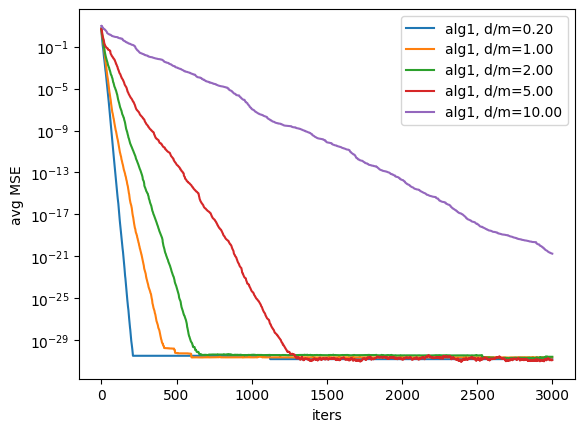

In [244]:
for item in range(len(d_over_m)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
#     plt.plot([i for i in range(len(loss_dm_ifca[item]))], loss_dm_ifca[item], label='ifca, d/m=%.2f' % d_over_m[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

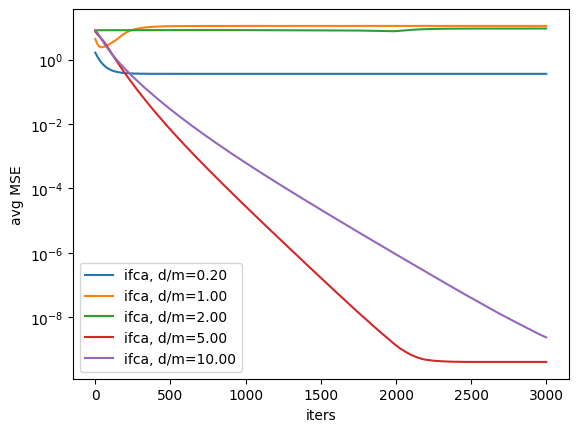

In [11]:
for item in range(len(d_over_m)):
#     plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
    plt.plot([i for i in range(len(loss_dm_ifca[item]))], loss_dm_ifca[item], label='ifca, d/m=%.2f' % d_over_m[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

In [ ]:
# # MSE for all the nodes
# for item in range(len(d_over_m)):
#     plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
# #     plt.plot([i for i in range(len(loss_dm_ifca[item]))], loss_dm_ifca[item], label='ifca, d/m=%.2f' % d_over_m[item])
# plt.yscale('log')
# plt.xlabel('iters')
# plt.ylabel('avg MSE')
# plt.legend()
# plt.show()

In [ ]:
# # MSE for all the nodes
# for item in range(len(d_over_m)):
# #     plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
#     plt.plot([i for i in range(len(loss_dm_ifca[item]))], loss_dm_ifca[item], label='ifca, d/m=%.2f' % d_over_m[item])
# plt.yscale('log')
# plt.xlabel('iters')
# plt.ylabel('avg MSE')
# plt.legend()
# plt.show()

In [12]:
import pandas as pd

In [13]:
x = [i for i in range(len(loss_dm_algo[0]))]
data = {'x': x}
for item in range(len(d_over_m)):
    data[d_over_m[item]] = loss_dm_algo[item]
    
df = pd.DataFrame.from_dict(data)

In [14]:
df.to_csv('clustered_FL_doverm.csv', sep=',')

In [15]:
x = [i for i in range(len(loss_dm_ifca[0]))]
data = {'x': x}
for item in range(len(d_over_m)):
    data[d_over_m[item]] = loss_dm_ifca[item]

df = pd.DataFrame.from_dict(data)    

In [16]:
df.to_csv('clustered_FL_ifca_doverm.csv', sep=',')

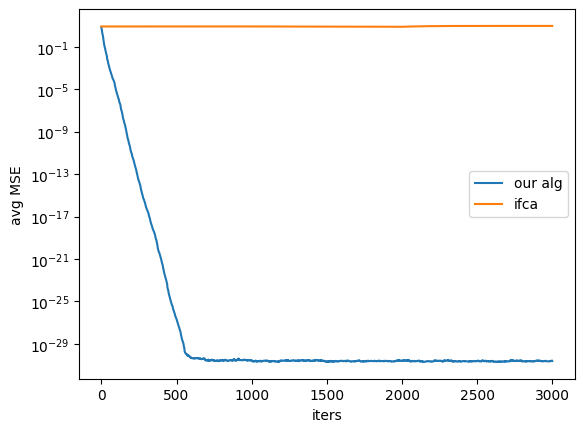

In [18]:
plt.plot([i for i in range(len(loss_dm_algo[2]))], loss_dm_algo[2], label='our alg')
plt.plot([i for i in range(len(loss_dm_ifca[2]))], loss_dm_ifca[2], label='ifca')
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

### Effect of noise in the algorithm performance

In [60]:
# d_over_m = 0.2
d_over_m = 2.0
noises = [0.0, 0.05, 0.1, 0.2, 0.5, 0.7, 1.0]
loss_dm_algo=[]
loss_dm_ifca=[]
K = 1500

for i in range(len(noises)):  
#     print(d_over_m[i])
    num_features = int(NUM_SAMPLES * d_over_m)
    X, y, w, clusters = get_data(num_features=num_features, noise=noises[i])
    true_w = []
    for c in range(NUM_CLUSTERS):    
        true_w.extend([w[c] for i in range(NUM_CLIENTS)])
    true_w = np.array(true_w)

    _, algo_loss_history = algorithm(X, y, w, clusters, K, SUBSET_SIZE, alpha)
    loss_dm_algo.append(algo_loss_history)    
    
#     results, models, train_cluster = ifca_main(X, y, w, clusters, alpha, num_epochs=K)
#     ifca_err = get_ifca_error(results, train_cluster)
#     loss_dm_ifca.append(ifca_err)

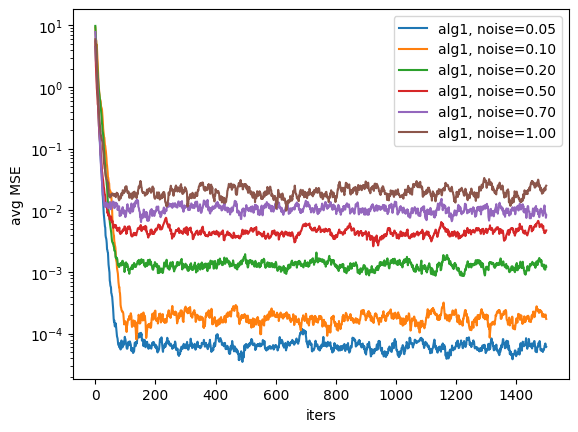

In [61]:
for item in range(len(noises)):
    if item == 0:
        continue
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, noise=%.2f' % noises[item])
#     plt.plot([i for i in range(len(loss_dm_ifca[item]))], loss_dm_ifca[item], label='ifca, d/m=%.2f' % d_over_m[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

In [62]:
x = [i for i in range(len(loss_dm_algo[0]))]
data = {'x': x}
for item in range(len(noises)):
    data[noises[item]] = loss_dm_algo[item]
    
df = pd.DataFrame.from_dict(data)

In [63]:
df.to_csv('clustered_FL_noises_dm2.0.csv', sep=',')

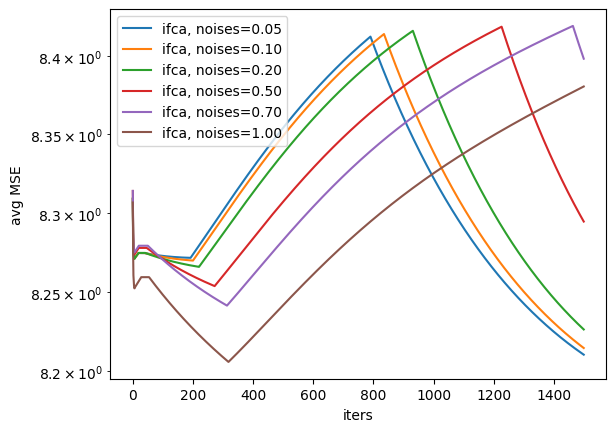

In [21]:
for item in range(len(noises)):
    if item == 0:
        continue
#     plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, noise=%.2f' % noises[item])
    plt.plot([i for i in range(len(loss_dm_ifca[item]))], loss_dm_ifca[item], label='ifca, noises=%.2f' % noises[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

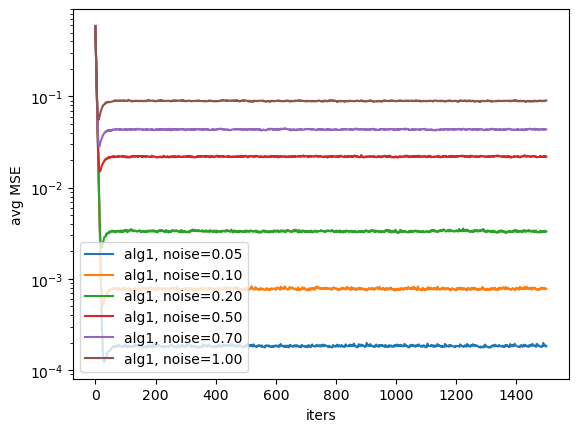

In [90]:
# MSE for all the nodes
for item in range(len(noises)):
    if item == 0:
        continue
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, noise=%.2f' % noises[item])
#     plt.plot([i for i in range(len(loss_dm_ifca[item]))], loss_dm_ifca[item], label='ifca, d/m=%.2f' % d_over_m[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

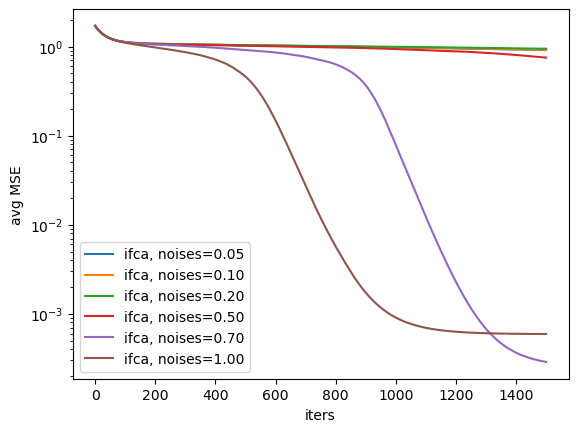

In [91]:
# MSE for all the nodes
for item in range(len(noises)):
    if item == 0:
        continue
#     plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, noise=%.2f' % noises[item])
    plt.plot([i for i in range(len(loss_dm_ifca[item]))], loss_dm_ifca[item], label='ifca, noises=%.2f' % noises[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

### Effect of sample size in the algorithm performance

#### For N = 100

In [73]:
from collections import defaultdict
subset_sizes = [5, 10, 15, 20, 30]
d_over_m = 2.0
loss_dm_algo = defaultdict(list)

for i in range(len(subset_sizes)):  
    subset_size = subset_sizes[i]
    print(subset_size)
    
    for _ in range(5):
    
        num_features = int(NUM_SAMPLES * d_over_m)
        X, y, w, clusters = get_data(num_features=num_features)
        true_w = []
        for c in range(NUM_CLUSTERS):    
            true_w.extend([w[c] for i in range(NUM_CLIENTS)])
        true_w = np.array(true_w)

        _, algo_loss_history = algorithm(X, y, w, clusters, K, subset_size, alpha)
        loss_dm_algo[subset_size].append(algo_loss_history)    

5
10
15
20
30


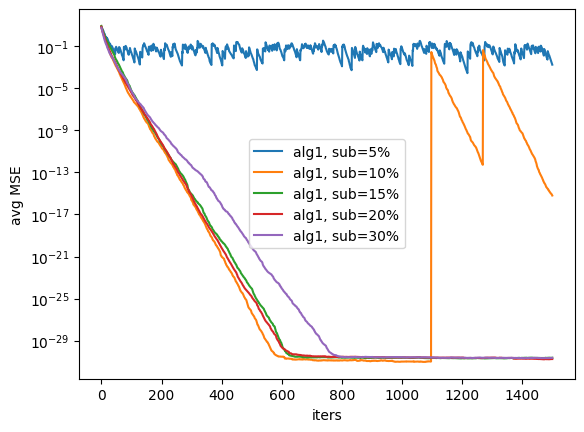

In [74]:
# for item in range(len(subset_sizes)):
for subset_size in subset_sizes:
#     plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
    sub_frac = (subset_size*100)/(NUM_CLUSTERS*NUM_CLIENTS)
    scores = np.array(loss_dm_algo[subset_size])
    scores = np.mean(scores, axis=0)
    plt.plot([i for i in range(len(scores))], scores, label='alg1, sub=%d%%' % sub_frac)
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

In [80]:
loss_dm_algo[5]

[[5.00085392172474,
  3.243891452867512,
  2.7162828437509203,
  2.0702581844542722,
  1.767925923071573,
  1.383546916637083,
  1.0074309485889152,
  0.8953899411686855,
  0.6368909078929043,
  0.5179407124116983,
  0.3767568133899353,
  0.25002458345863204,
  0.22088884543720924,
  0.1897611952081675,
  0.16778021373568497,
  0.13828548027496218,
  0.10686042741521853,
  0.09428125036478523,
  0.07009934935582934,
  0.05481961646146641,
  0.5319642243673468,
  0.4688784739999016,
  0.3624851472947911,
  0.28241769641166947,
  0.17255381475553452,
  0.1412492370476344,
  0.1053012420722938,
  0.0930870624462612,
  0.0745227507985795,
  0.06350514140340045,
  0.04056163718519058,
  0.03280205296944678,
  0.028772072038677817,
  0.02431900819118503,
  0.02012550519789336,
  0.0177953280621224,
  0.01464607133030605,
  0.011090678432589941,
  0.00777299360751511,
  0.006186637214047348,
  0.0053697857766038335,
  0.004208968987790597,
  0.00369532324750955,
  0.0030822662529904005,
  0.0

In [90]:
x = [i for i in range(len(loss_dm_algo[subset_sizes[0]][0]))]
# print(len(loss_dm_algo[subset_sizes[0]][0]))
data = {'x': x}
for subset_size in subset_sizes:
    sub_frac = (subset_size*100)/(NUM_CLUSTERS*NUM_CLIENTS)
    scores = np.array(loss_dm_algo[subset_size])
    scores = np.mean(scores, axis=0)
    data[sub_frac] = scores
    
df = pd.DataFrame.from_dict(data)

df.to_csv('clustered_FL_subset_dm2.0.csv', sep=',')

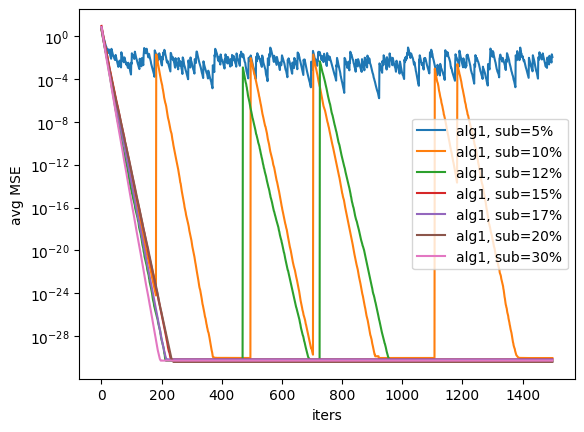

In [26]:
#d/m=0.2
# for item in range(len(subset_sizes)):
for subset_size in subset_sizes:
#     plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
    sub_frac = (subset_size*100)/(NUM_CLUSTERS*NUM_CLIENTS)
    scores = np.array(loss_dm_algo[subset_size])
    scores = np.mean(scores, axis=0)
    plt.plot([i for i in range(len(scores))], scores, label='alg1, sub=%d%%' % sub_frac)
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

#### For N = 200

In [29]:
subset_sizes = [5, 10, 20, 30, 40, 50, 60]
d_over_m = 0.2
loss_dm_algo = defaultdict(list)
num_clients = 100

for i in range(len(subset_sizes)):  
    subset_size = subset_sizes[i]
    print(subset_size)
    
    for _ in range(5):
    
        num_features = int(NUM_SAMPLES * d_over_m)
        X, y, w, clusters = get_data(num_features=num_features, num_clients=num_clients)
        true_w = []
        for c in range(NUM_CLUSTERS):    
            true_w.extend([w[c] for i in range(num_clients)])
        true_w = np.array(true_w)

        _, algo_loss_history = algorithm(X, y, w, clusters, K, subset_size, alpha)
        loss_dm_algo[subset_size].append(algo_loss_history)    

5
10
20
30
40
50
60


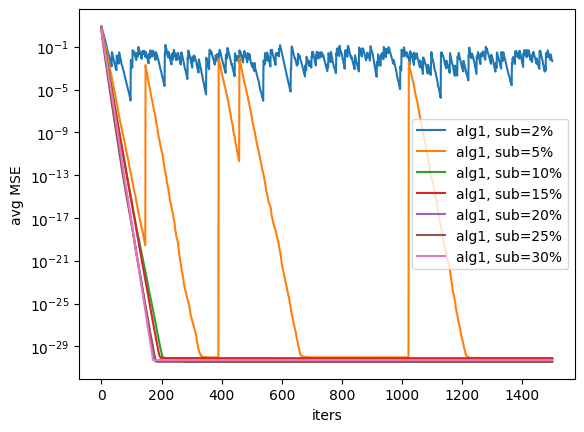

In [30]:
# for item in range(len(subset_sizes)):
for subset_size in subset_sizes:
#     plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
    sub_frac = (subset_size*100)/(NUM_CLUSTERS*num_clients)
    scores = np.array(loss_dm_algo[subset_size])
    scores = np.mean(scores, axis=0)
    plt.plot([i for i in range(len(scores))], scores, label='alg1, sub=%d%%' % sub_frac)
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

#### For N = 400

In [31]:
subset_sizes = [10, 20, 30, 40, 50, 60]
d_over_m = 0.2
loss_dm_algo = defaultdict(list)
num_clients = 200


for i in range(len(subset_sizes)):  
    subset_size = subset_sizes[i]
    print(subset_size)
    
    for _ in range(5):
    
        num_features = int(NUM_SAMPLES * d_over_m)
        X, y, w, clusters = get_data(num_features=num_features, num_clients=num_clients)
        true_w = []
        for c in range(NUM_CLUSTERS):    
            true_w.extend([w[c] for i in range(num_clients)])
        true_w = np.array(true_w)

        _, algo_loss_history = algorithm(X, y, w, clusters, K, subset_size, alpha)
        loss_dm_algo[subset_size].append(algo_loss_history)    

10
20
30
40
50
60


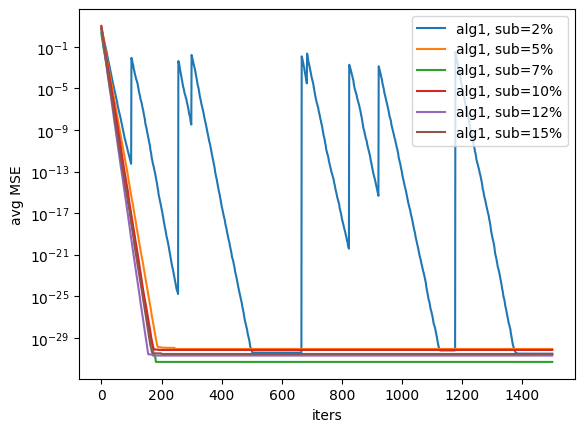

In [32]:
# for item in range(len(subset_sizes)):
for subset_size in subset_sizes:
#     plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
    sub_frac = (subset_size*100)/(NUM_CLUSTERS*num_clients)
    scores = np.array(loss_dm_algo[subset_size])
    scores = np.mean(scores, axis=0)
    plt.plot([i for i in range(len(scores))], scores, label='alg1, sub=%d%%' % sub_frac)
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

### Sin data

In [12]:
def get_sin_data(num_clients=NUM_CLIENTS, num_training_samples=NUM_SAMPLES, noise=0.0):
    interval_width = (10 - (-10)) / num_clients

    # Generate the intervals
    intervals = [(i * interval_width-10, (i + 1) * interval_width-10) for i in range(num_clients)]

    # Generate data for each node
    X = np.zeros((num_clients,num_training_samples, 1)) 
    y = np.zeros ((num_clients,num_training_samples))
    for i, (start, end) in enumerate(intervals):
        x = np.linspace(start, end, num_training_samples)
        X[i] = x.reshape(-1, 1)
        y[i] = np.sin(x) + np.random.normal(0, noise)
    
    
    return X, y, None, None


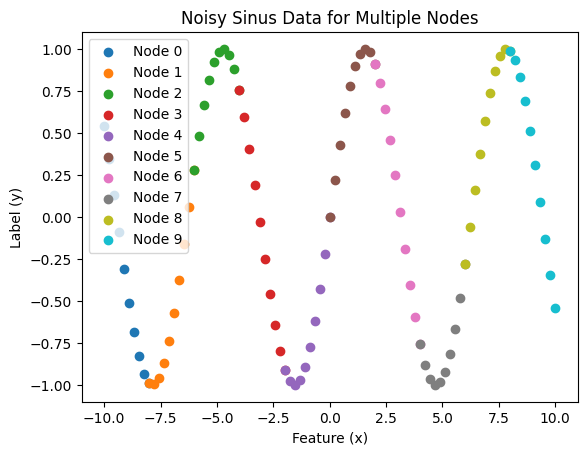

In [62]:
clients = [10, 20, 30, 40, 50]
loss_dm_algo=[]
for s in range(len(clients)):  
    num_clients = clients[s]
    X, y, w, clusters = get_sin_data(num_clients=num_clients, num_training_samples=10)
    if s == 0:
        for i in range(len(X)):
            plt.scatter(X[i], y[i], label=f'Node {i}')
        plt.xlabel('Feature (x)')
        plt.ylabel('Label (y)')
        plt.title('Noisy Sinus Data for Multiple Nodes')
        plt.legend()
        plt.show()
    
    _, algo_loss_history = algorithm(X, y, w, clusters, 100, num_clients//2, alpha, loss_model='y')
    loss_dm_algo.append(algo_loss_history)    


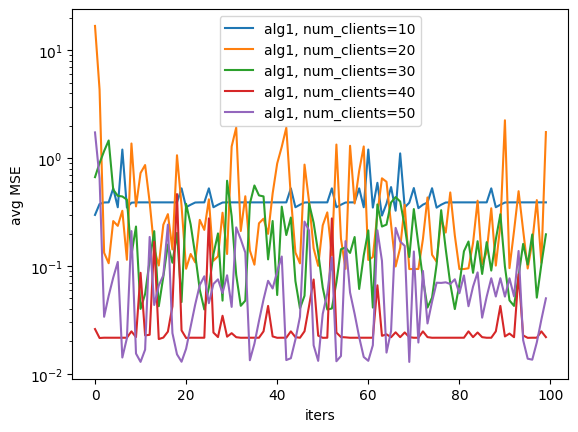

In [63]:
for item in range(len(clients)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, num_clients=%d' % clients[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

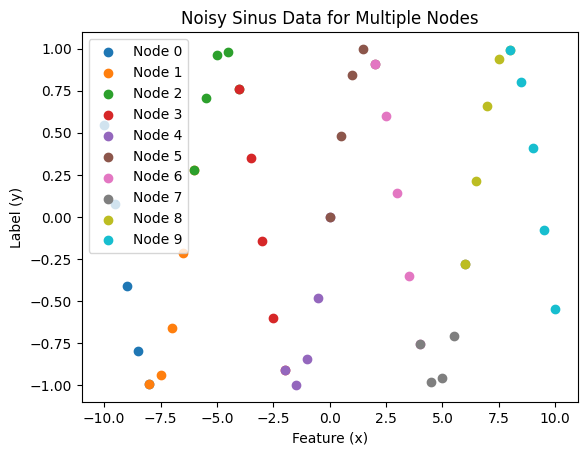

In [58]:
samples = [5, 10, 20, 30]
loss_dm_algo=[]
num_clients = 10
for s in range(len(samples)):  
    num_samples = samples[s]
    X, y, w, clusters = get_sin_data(num_clients=num_clients, num_training_samples=num_samples)
    if s == 0:
        for i in range(len(X)):
            plt.scatter(X[i], y[i], label=f'Node {i}')
        plt.xlabel('Feature (x)')
        plt.ylabel('Label (y)')
        plt.title('Noisy Sinus Data for Multiple Nodes')
        plt.legend()
        plt.show()
    
    _, algo_loss_history = algorithm(X, y, w, clusters, 100, num_clients//2, alpha, loss_model='y')
    loss_dm_algo.append(algo_loss_history)    


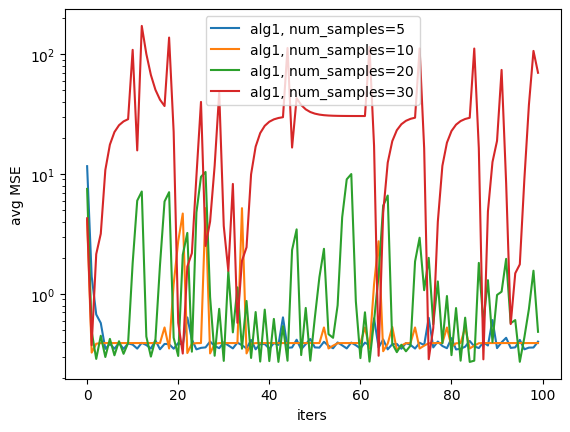

In [61]:
for item in range(len(samples)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, num_samples=%d' % samples[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

## Non-parametric model

In [67]:
def get_non_param_data(num_features, num_clusters=NUM_CLUSTERS, num_clients=NUM_CLIENTS, num_training_samples=NUM_SAMPLES, noise=0.0):
    w = np.random.uniform(-5,5,(num_clusters,num_features)) # here we shape all w for all clients
    clusters = []

    X = np.zeros((num_clusters,num_clients,num_training_samples,num_features)) 
    X_test = np.random.randn(num_training_samples,num_features)

    y = np.zeros ((num_clusters,num_clients,num_training_samples))
    localdatasets = np.zeros((num_clusters,num_clients,num_training_samples,(num_features+1)))
    clusterassgts = np.zeros((num_clusters,num_clients,num_training_samples))
    
    
    for iter_cluster in range(num_clusters): 
        for iter_node in range(0, num_clients):
            X[iter_cluster, iter_node,:,:] = np.random.randn(num_training_samples, num_features)
            r = X[iter_cluster, iter_node,:,:] @ w[iter_cluster, :].reshape(-1, 1) + np.random.normal(loc=0.0, scale=noise, size=(num_training_samples, 1))
            y[iter_cluster, iter_node,:] = r.squeeze()
            clusters.append(iter_cluster)
            for iter_sample in range(0,num_training_samples): 
                localdatasets[iter_cluster,iter_node,iter_sample,:] = np.hstack((X[iter_cluster, iter_node,iter_sample,:],y[iter_cluster, iter_node,iter_sample].reshape(-1,))).reshape(1,-1)
                clusterassgts[iter_cluster,iter_node,iter_sample] = iter_cluster


    X = X.reshape(-1, X.shape[2], X.shape[3])
    y = y.reshape(-1, y.shape[2])
    
    
    return X, y, w, clusters, X_test


### DecisionTreeRegressor

In [65]:
# from sklearn.tree import DecisionTreeRegressor
# from copy import deepcopy


# def MSE(y_true, y_pred):
#     m = len(y)
#     loss = (1 / m) * np.sum((y_pred - y_true) ** 2)
#     return loss

# def custom_loss(y_true, y_pred, lambda_value):
# #     loss = np.mean(np.square(y_true - y_pred))  # Squared Euclidean distance
#     loss = MSE(y_true, y_pred)
# #     regularization_term = lambda_value * some_regularization_function(tree)  # Adjust as needed
#     regularization_term = 0
#     return loss + regularization_term

# def non_param_algorithm(X, X_test, y, w, clusters, K, subset_size, alpha):
#     N = X.shape[0]
#     nodes = [i for i in range(N)]
#     w_hat = [DecisionTreeRegressor(max_depth=1, min_samples_split=1000) for _ in range(N)]
#     loss_history = []
    
#     for i in range(N):
#         w_hat[i].fit(X[i], y[i])
    
#     mse = 0
#     rewards = []
#     new_X = [X[i] for i in range(N)]
#     new_y = [y[i] for i in range(N)]
#     for k in range(K):
#         loss = []
# #         print(k, mse, rewards, len(new_X[0]))
#         for i in range(N):
#             if i != 0:
#                 continue
#             selected_nodes = random.sample(nodes, subset_size+1)
#             if i in selected_nodes:
#                 selected_nodes.remove(i)
#             selected_nodes = selected_nodes[:subset_size] 
            
#             rewards = []
#             _trees = []
#             _Xs = []
#             _ys = []
#             _sample_weights = []
#             for node in selected_nodes:
#                 updated_loss = custom_loss(y[node], w_hat[i].predict(X[node]), alpha)
#                 _X = np.concatenate([new_X[i], X[node]])
#                 _Xs.append(_X)
#                 _y = np.concatenate([w_hat[i].predict(new_X[i]), y[node]])
#                 _ys.append(_y)
#                 sample_weight = np.concatenate([np.ones_like(new_y[i]), np.ones_like(y[node]) * updated_loss])
                
#                 _tree = DecisionTreeRegressor(max_depth=1, min_samples_split=1000)
#                 _tree.fit(_X, _y, sample_weight=sample_weight)
#                 _trees.append(_tree)
#                 # losses instead of rewards
#                 rewards.append(updated_loss)
# #                 rewards.append(MSE(y[i], _tree.predict(X[i])))
                
#             idx = np.argmin(rewards)
#             best_tree = _trees[idx]
#             new_X[i] = _Xs[idx]
#             new_y[i] = _ys[idx]
            

#             w_hat[i] = deepcopy(best_tree)   
            
#             mse = MSE(y[i], w_hat[i].predict(X[i]))
#             loss.append(mse)
#         loss_history.append(np.mean(loss))
            
#     return w_hat, loss_history

In [251]:
from sklearn.tree import DecisionTreeRegressor
from copy import deepcopy


def MSE(y_true, y_pred):
    m = len(y)
    loss = (1 / m) * np.sum((y_pred - y_true) ** 2)
    return loss

def custom_loss(y_true, y_pred, lambda_value):
#     loss = np.mean(np.square(y_true - y_pred))  # Squared Euclidean distance
    loss = MSE(y_true, y_pred)
#     regularization_term = lambda_value * some_regularization_function(tree)  # Adjust as needed
    regularization_term = 0
    return lambda_value * (loss + regularization_term)

def non_param_algorithm(X, X_test, y, w, clusters, K, subset_size, alpha):
    N = X.shape[0]
    nodes = [i for i in range(N)]
    w_hat = [DecisionTreeRegressor(max_depth=1, min_samples_split=1000) for _ in range(N)]
    loss_history = []
    
    for i in range(N):
        w_hat[i].fit(X[i], y[i])
    
    mse = 0
    rewards = []
    new_X = [X[i] for i in range(N)]
    new_y = [y[i] for i in range(N)]
    sample_weighs = [np.ones_like(new_y[i]) for i in range(N)]
    for k in range(K):
        loss = []
#         print(k, mse, rewards, len(new_X[0]))
        for i in range(N):
            if i != 0:
                continue
            selected_nodes = random.sample(nodes, subset_size+1)
            if i in selected_nodes:
                selected_nodes.remove(i)
            selected_nodes = selected_nodes[:subset_size] 
            
            rewards = []
            _trees = []
            _Xs = []
            _ys = []
            _sample_weights = []
            for node in selected_nodes:
                updated_loss = custom_loss(y[node], w_hat[i].predict(X[node]), alpha)
                _X = np.concatenate([new_X[i], X[node]])
                _Xs.append(_X)
                _y = np.concatenate([w_hat[i].predict(new_X[i]), y[node]])
                _ys.append(_y)
#                 sample_weight = np.concatenate([np.ones_like(new_y[i]), np.ones_like(y[node]) * updated_loss])
                sample_weight = np.concatenate([sample_weighs[i], np.ones_like(y[node]) * alpha])
                _sample_weights.append(sample_weight)
                
                _tree = DecisionTreeRegressor(max_depth=1, min_samples_split=1000)
                _tree.fit(_X, _y, sample_weight=sample_weight)
#                 _tree.fit(_X, _y)
                _trees.append(_tree)
                # losses instead of rewards
                rewards.append(updated_loss)
#                 rewards.append(MSE(y[i], _tree.predict(X[i])))
                
            idx = np.argmin(rewards)
            best_tree = _trees[idx]
            new_X[i] = _Xs[idx]
            new_y[i] = _ys[idx]
            sample_weighs[i] = _sample_weights[idx]
            

            w_hat[i] = deepcopy(best_tree)   
            
            mse = MSE(y[i], w_hat[i].predict(X[i]))
            loss.append(mse)
        loss_history.append(np.mean(loss))
            
    return w_hat, loss_history

In [95]:
# K = 50
# d_over_m = [0.2, 1, 2.5, 5, 10]
# loss_dm_algo=[]
# for i in range(len(d_over_m)):  
#     num_features = int(NUM_SAMPLES * d_over_m[i])
#     X, y, w, clusters, X_test = get_non_param_data(num_features=num_features, noise=0.0, num_clients=50)
#     for i in range(len(X)):
#         X[i] = X[0]
#         y[i] = y[0]
#     _, algo_loss_history = non_param_algorithm(X, X_test, y, w, clusters, K, 20, alpha)
#     loss_dm_algo.append(algo_loss_history)

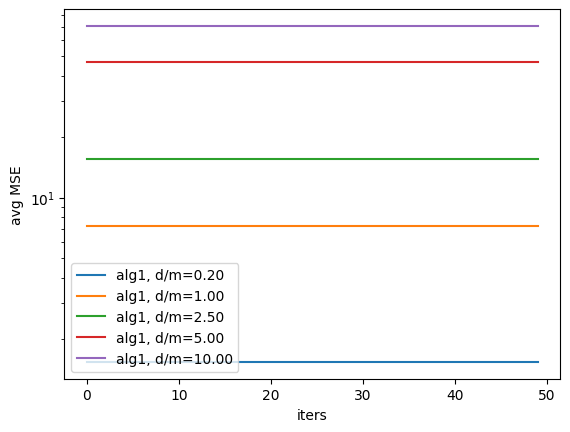

In [96]:
# for item in range(len(d_over_m)):
#     plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
# plt.yscale('log')
# plt.xlabel('iters')
# plt.ylabel('avg MSE')
# plt.legend()
# plt.show()

In [245]:
K = 200
num_samples = [5, 10, 20, 50, 100]
num_features = 10 
alpha = 0.7
loss_dm_algo=[]
for num_sample in num_samples:
#     print(num_sample)
    X, y, w, clusters, X_test = get_non_param_data(num_features=num_features, noise=0.0, num_training_samples=num_sample, num_clients=50)
    _, algo_loss_history = non_param_algorithm(X, X_test, y, w, clusters, K, 10, alpha)
    loss_dm_algo.append(algo_loss_history)

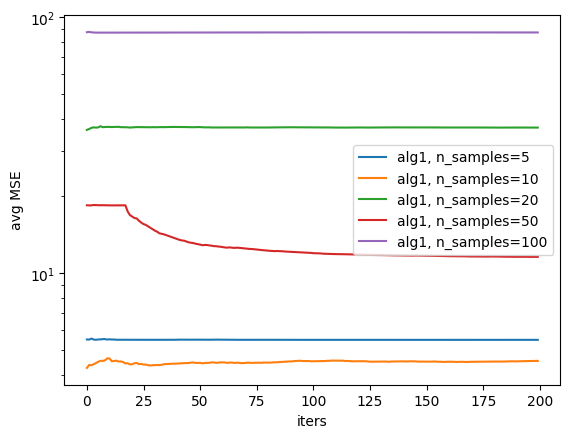

In [243]:
# no leaf
# 0.7
# sample weight

for item in range(len(loss_dm_algo)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, n_samples=%d' % num_samples[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend(loc='right')
plt.show()

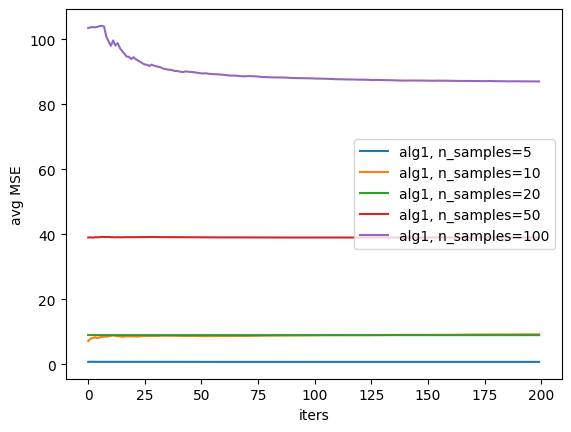

In [246]:
# no leaf
# 0.7
# no sample weight

for item in range(len(loss_dm_algo)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, n_samples=%d' % num_samples[item])
# plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend(loc='right')
plt.show()

In [256]:
K = 200
num_samples = [5, 10, 20, 50, 100]
num_features = 10 
alpha = 0.7
loss_dm_algo=[]
for num_sample in num_samples:
#     print(num_sample)
    X, y, w, clusters, X_test = get_non_param_data(num_features=num_features, noise=0.5, num_training_samples=num_sample, num_clients=50)
    _, algo_loss_history = non_param_algorithm(X, X_test, y, w, clusters, K, 10, alpha)
    loss_dm_algo.append(algo_loss_history)

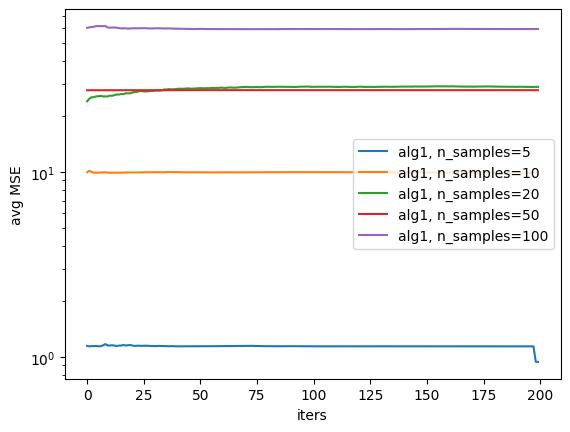

In [258]:
# no leaf
# 0.7
# sample weight

for item in range(len(loss_dm_algo)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, n_samples=%d' % num_samples[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend(loc='right')
plt.show()

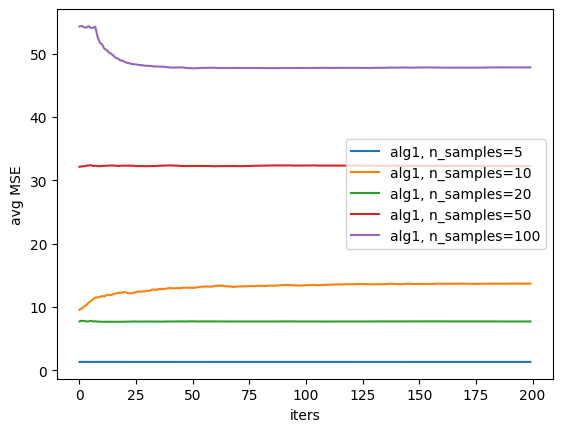

In [250]:
# no leaf
# 0.7
# no sample weight

for item in range(len(loss_dm_algo)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, n_samples=%d' % num_samples[item])
# plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend(loc='right')
plt.show()

In [235]:
K = 200
d_over_m = [0.2, 1, 2.5, 5, 10]
loss_dm_algo=[]
for i in range(len(d_over_m)):  
    num_features = int(NUM_SAMPLES * d_over_m[i])
    X, y, w, clusters, X_test = get_non_param_data(num_features=num_features, noise=0.0, num_clients=50)
    _, algo_loss_history = non_param_algorithm(X, X_test, y, w, clusters, K, 10, alpha)
    loss_dm_algo.append(algo_loss_history)

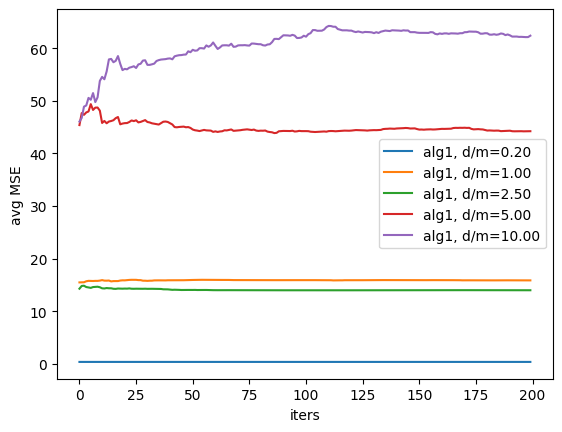

In [237]:
for item in range(len(d_over_m)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
# plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

In [238]:
K = 200
d_over_m = [0.2, 1, 2.5, 5, 10]
loss_dm_algo=[]
for i in range(len(d_over_m)):  
    num_features = int(NUM_SAMPLES * d_over_m[i])
    X, y, w, clusters, X_test = get_non_param_data(num_features=num_features, noise=0.5, num_clients=50)
    _, algo_loss_history = non_param_algorithm(X, X_test, y, w, clusters, K, 10, alpha)
    loss_dm_algo.append(algo_loss_history)

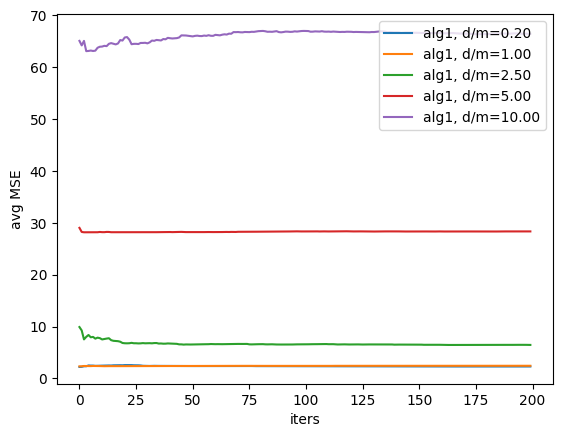

In [239]:
for item in range(len(d_over_m)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
# plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

In [293]:
n_points=1000
interval_size= 4
points_X = np.random.uniform(0, interval_size, (n_points, 2))

# for sub_interval1 in range(0, interval_size-1, 1):
#     for sub_interval2 in range(0, interval_size-1, 1):
#         print((sub_interval1, sub_interval2), (sub_interval1+2, sub_interval2+2))
#             print(np.where(sub_interval1<= points_X[:, 0]<sub_interval1+2))
#             break
sub_interval1 = 0
sub_interval2 = 0
selected_x = points_X[np.where((points_X[:, 0] >= sub_interval1) & (points_X[:, 0] < sub_interval1+2) 
                      & (points_X[:, 1] >= sub_interval2) & (points_X[:, 1] < sub_interval2+2))[0]]
print(np.max(selected_x[:, 0]), np.min(selected_x[:, 0]), np.max(selected_x[:, 1]), np.min(selected_x[:, 1]))


1.9994710895676846 0.001445141520668436 1.991968051525793 0.003919887799501698


### testing dt

In [97]:
from scipy import ndimage
from matplotlib.colors import ListedColormap

cm2 = ListedColormap(['#0000aa', '#ff2020'])
colors = np.array(['#0000aa', '#ff2020'])

def plot_tree_partition(X, y, tree, ax=None, min_value=0, max_value=6, eps=0.25):
    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
#     x_min, y_min = min_value, min_value
#     x_max, y_max = max_value, max_value
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    

    Z = tree.predict(X_grid)
    Z = Z.reshape(X1.shape)
    faces = tree.apply(X_grid)
    faces = faces.reshape(X1.shape)
    border = ndimage.laplace(faces) != 0
    ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
    ax.scatter(X1[border], X2[border], marker='.', s=1)
    

    ax.scatter(X[:, 0], X[:, 1], c=colors[y])
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)
    ax.set_xticks(())
    ax.set_yticks(())
    return ax

In [284]:
from sklearn.model_selection import train_test_split


def split_array_into_chunks(arr, k):
    return [arr[i:i+k] for i in range(0, len(arr), k)]


def get_test_non_param_data(n_points=1000):
    interval_size = 4
    clusters = []
    delta = 0.25

    points_X = np.random.uniform(0, interval_size, (n_points, 2))
#     points_y = np.array([int(points_X[i][0]+points_X[i][1]) % 2 for i in range(n_points)])
    
    X = []
    y = []
    
    min_size = n_points
    
#     for sub_interval1 in range(0, interval_size-1, 1):
    cnt = 0
    for sub_interval1 in range(0, interval_size-1, 2):
        for sub_interval2 in range(0, interval_size-1, 2):            
            selected_idx = np.where((points_X[:, 0] >= sub_interval1) & (points_X[:, 0] < sub_interval1+2) 
                                  & (points_X[:, 1] >= sub_interval2) & (points_X[:, 1] < sub_interval2+2))[0]
            
            selected_x = points_X[selected_idx]
            
            selected_x[:, 0] = np.where(selected_x[:, 0] > sub_interval1+delta, selected_x[:, 0], sub_interval1+delta)
            selected_x[:, 0] = np.where(selected_x[:, 0] < sub_interval1+2-delta, selected_x[:, 0], sub_interval1+2-delta)

            selected_x[:, 1] = np.where(selected_x[:, 1] > sub_interval2+delta, selected_x[:, 1], sub_interval2+delta)
            selected_x[:, 1] = np.where(selected_x[:, 1] < sub_interval2+2-delta, selected_x[:, 1], sub_interval2+2-delta)

            
#             selected_y = points_y[selected_idx]
#             selected_y = [(int(selected_x[i][0])+cnt) % 2 for i in range(len(selected_x))]
            selected_y = list(map(lambda x: int(x[0] + x[1] > (sub_interval1 + sub_interval2 + 2)), selected_x))
            if cnt != 0:
                selected_y = 1-np.array(selected_y)
        
            min_size = min(min_size, len(selected_idx))

            X.append(selected_x)
            y.append(selected_y)  
            cnt += 1
            
    new_X = []
    new_y = []
    X_tests = []
    y_tests = []

    for i in range(len(X)):
#         X[i] = X[i][:min_size]
#         y[i] = y[i][:min_size]
        X[i] = X[i][:100]
        y[i] = y[i][:100]
        
#         selected_idx = random.sample(the_list, 50)
        
#         new_X.append(X[i][:min_size//2])
#         new_X.append(X[i][min_size//2:])
        
#         new_y.append(y[i][:min_size//2])
#         new_y.append(y[i][min_size//2:])

        _X, X_test, _y, y_test = train_test_split(X[i], y[i], test_size=0.3, random_state=42)
    
        X_test = np.array(X_test)
        y_test = np.array(y_test)


        
        # Example usage:
        x_chunks = split_array_into_chunks(_X, 10)
        new_X += x_chunks[:-1]
        y_chunks = split_array_into_chunks(_y, 10)
        new_y += y_chunks[:-1]
        for j in range(len(x_chunks)-1):
            random_indices = random.sample(range(len(X_test)), int(len(X_test)*0.3))
            X_tests.append(X_test[random_indices])
            y_tests.append(y_test[random_indices])
           
    
    X = np.array(new_X)
    y = np.array(new_y)
    X_test = np.array(X_tests)
    y_test = np.array(y_tests)
    
    return X, y, X_test, y_test, _X, _y


In [219]:
from sklearn import tree
from sklearn.metrics import log_loss
from copy import deepcopy


def MSE(y_true, y_pred):
    logloss = log_loss(y_true, y_pred, labels=[0, 1])
    return logloss

def custom_log_loss(y_true, y_pred, lambda_value):
    logloss = log_loss(y_true, y_pred, labels=[0, 1])
    return lambda_value * (logloss)

def non_param_algorithm(X, X_test, y, y_test, _X, _y, K, subset_size, alpha):
    N = X.shape[0]
    nodes = [i for i in range(N)]
    w_hat = [tree.DecisionTreeClassifier(max_depth=2) for _ in range(N)]
    loss_history = []
    
    loss = []
    for i in range(N):
        if i != 0:
            continue
        w_hat[i].fit(X[i], y[i])
        mse = MSE(y_test[i], w_hat[i].predict(X_test[i]))
        loss.append(mse)
    loss_history.append(np.mean(loss))
        
    fig, axes = plt.subplots(1, 1, figsize=(3, 3))
    for i in range(len(w_hat)):
        if i != 0:
            continue
        ax.set_title("Tree {}".format(i))
        plot_tree_partition(X_test[i], y_test[i], w_hat[i], ax=axes, eps=0.2)
    
    mse = 0
    rewards = []
    new_X = [X[i] for i in range(N)]
    new_y = [y[i] for i in range(N)]
    sample_weighs = [np.ones_like(new_y[i]) for i in range(N)]
    for k in range(K):
        loss = []
#         print(k, mse, rewards, len(new_X[0]))
        for i in range(N):
            if i != 0:
                continue
            selected_nodes = random.sample(nodes, subset_size+1)
#             selected_nodes += [j for j in range(max(i-20, 0),min(i+20, N))]
            random.shuffle(selected_nodes)
            while i in selected_nodes:
                selected_nodes.remove(i)
                
            selected_nodes = selected_nodes[:subset_size] 
            
            rewards = []
            _trees = []
            _Xs = []
            _ys = []
            _sample_weights = []
            for node in selected_nodes:
#                 updated_loss = custom_loss(y_test[node], w_hat[i].predict(X_test[node]), alpha)
                updated_loss = custom_log_loss(y_test[node], w_hat[i].predict(X_test[node]), alpha)
#                 print(updated_loss)
                _X = np.concatenate([new_X[i], X_test[node]])
                _Xs.append(_X)
                _y = np.concatenate([w_hat[i].predict(new_X[i]), y_test[node]])
#                 _y = np.concatenate([new_y[i], y[node]])
                _ys.append(_y)
#                 sample_weight = np.concatenate([np.ones_like(new_y[i]), np.ones_like(y[node])])
                sample_weight = np.concatenate([sample_weighs[i], np.ones_like(y_test[node]) * alpha])
                _sample_weights.append(sample_weight)
                
                _tree = tree.DecisionTreeClassifier(max_depth=2)
                _tree.fit(_X, _y, sample_weight=sample_weight)
#                 _tree.fit(_X, _y)
                _trees.append(_tree)
                rewards.append(updated_loss)
                
            idx = np.argmin(rewards)
            current_loss = custom_log_loss(y_test[i], w_hat[i].predict(X_test[i]), alpha)
#             if current_loss >= rewards[idx]:
            if True:
#                 print(idx, current_loss, rewards[idx])
                best_tree = _trees[idx]
                new_X[i] = _Xs[idx]
                new_y[i] = _ys[idx]
                sample_weighs[i] = _sample_weights[idx]
#                 new_X[i] = X[i]
#                 new_y[i] = y[i]
#                 sample_weighs[i] = np.ones_like(y[i])
            

                w_hat[i] = deepcopy(best_tree)  
            
#             if i == 0:
#                 if k % 100 == 0:
#                     print(k)
#                     fig, axes = plt.subplots(1, 1, figsize=(3, 3))
#                     for _i in range(N):
#                         if _i != 0:
#                             continue
#                         ax.set_title("Tree {}".format(_i))
#                         plot_tree_partition(new_X[_i], new_y[_i], w_hat[_i], ax=axes, eps=0.2)
            
            
#             mse = MSE(y_test[i], w_hat[i].predict(X_test[i]))
            mse = MSE(_y, w_hat[i].predict(_X))
            loss.append(mse)
        loss_history.append(np.mean(loss))
        
    return w_hat, loss_history, w_hat

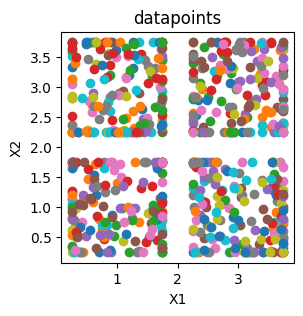

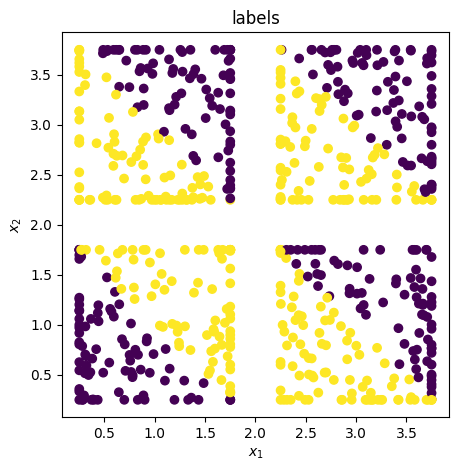

In [266]:
X, y, X_test, y_test, _X, _y = get_test_non_param_data()

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
for item in range(len(X)):
    ax.scatter(X[item, :, 0], X[item, :, 1])
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('datapoints')
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for item in range(len(X)):
    ax.scatter(X[item, :, 0], X[item, :, 1], c=y[item])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('labels')
plt.savefig('non_param_datapoints.pdf')
plt.show()




In [220]:
print(len(X), len(X[0]), len(X_test[0]))
K = 3000

64 10 21


0
1
2


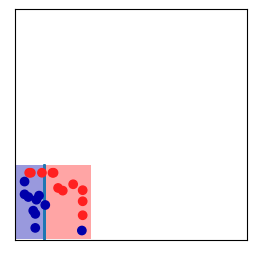

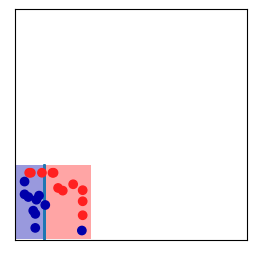

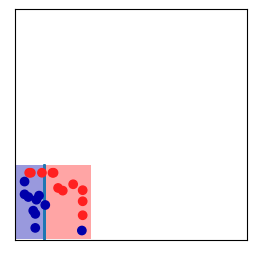

In [226]:
K = 3000
results = []
for i in range(3):
    print(i)
    _, algo_loss_history, w_hat = non_param_algorithm(X, X_test, y, y_test, _X, _y, K, len(X)//3, alpha)
    results.append(algo_loss_history)
    
results = np.array(results)
algo_loss_history = np.mean(results, axis=0)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


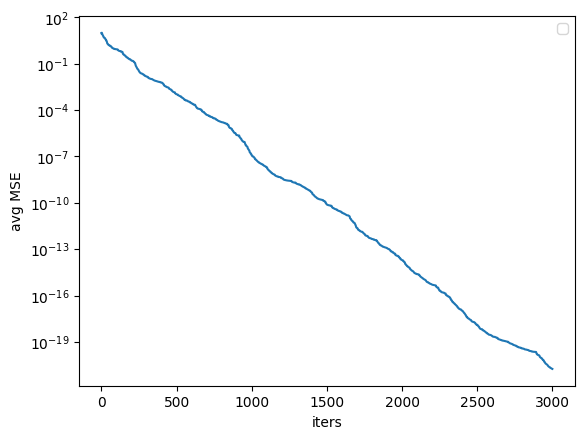

In [246]:
# 30% test
plt.plot([i for i in range(len(algo_loss_history))], algo_loss_history)
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

In [245]:
x = [i for i in range(len(algo_loss_history))]
# print(len(loss_dm_algo[subset_sizes[0]][0]))
data = {'x': x}
data['y'] = algo_loss_history
    
df = pd.DataFrame.from_dict(data)

df.to_csv('clustered_FL_nonparam.csv', sep=',')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


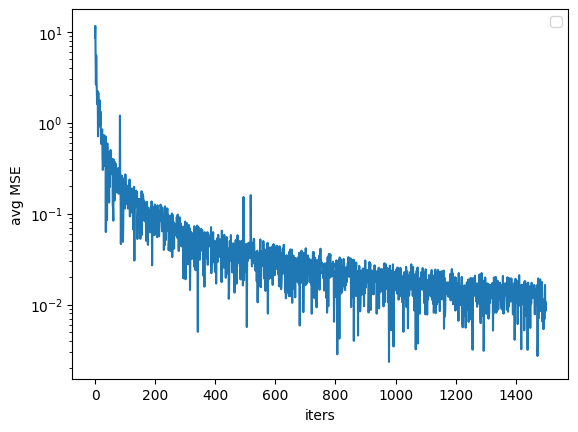

In [209]:
# 30% test
plt.plot([i for i in range(len(algo_loss_history))], algo_loss_history)
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


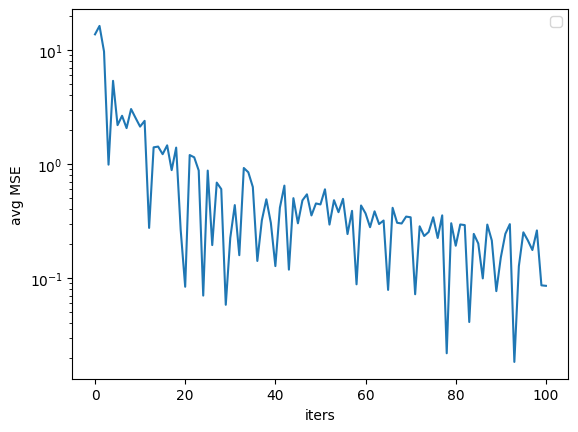

In [183]:
# 30% test
plt.plot([i for i in range(len(algo_loss_history))], algo_loss_history)
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


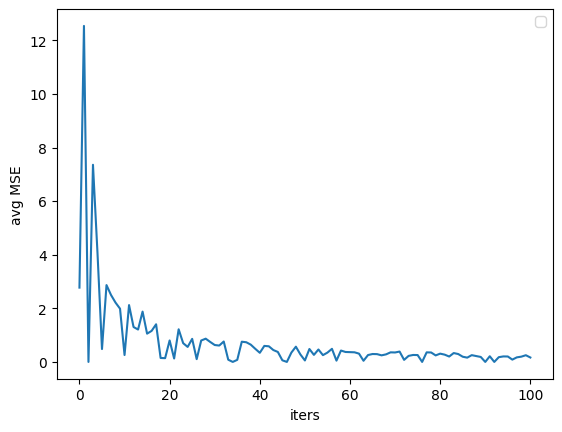

In [175]:
# 20% test
plt.plot([i for i in range(len(algo_loss_history))], algo_loss_history)
# plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

## Paper algo

In [8]:
from scipy import ndimage
from matplotlib.colors import ListedColormap

cm2 = ListedColormap(['#0000aa', '#ff2020'])
colors = np.array(['#0000aa', '#ff2020'])

def plot_tree_partition(X, y, tree, ax=None, min_value=0, max_value=6, eps=0.25):
    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
#     x_min, y_min = min_value, min_value
#     x_max, y_max = max_value, max_value
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    

    Z = tree.predict(X_grid)
    Z = Z.reshape(X1.shape)
    faces = tree.apply(X_grid)
    faces = faces.reshape(X1.shape)
    border = ndimage.laplace(faces) != 0
    ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
    ax.scatter(X1[border], X2[border], marker='.', s=1)
    

    ax.scatter(X[:, 0], X[:, 1], c=colors[y])
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)
    ax.set_xticks(())
    ax.set_yticks(())
    return ax

In [3]:
from sklearn.model_selection import train_test_split


def split_array_into_chunks(arr, k):
    return [arr[i:i+k] for i in range(0, len(arr), k)]


def get_test_non_param_data(n_points=1000):
    interval_size = 4
    clusters = []
    delta = 0.25

    points_X = np.random.uniform(0, interval_size, (n_points, 2))
#     points_y = np.array([int(points_X[i][0]+points_X[i][1]) % 2 for i in range(n_points)])
    
    X = []
    y = []
    
    min_size = n_points
    
#     for sub_interval1 in range(0, interval_size-1, 1):
    cnt = 0
    for sub_interval1 in range(0, interval_size-1, 2):
        for sub_interval2 in range(0, interval_size-1, 2):            
            selected_idx = np.where((points_X[:, 0] >= sub_interval1) & (points_X[:, 0] < sub_interval1+2) 
                                  & (points_X[:, 1] >= sub_interval2) & (points_X[:, 1] < sub_interval2+2))[0]
            
            selected_x = points_X[selected_idx]
            
            selected_x[:, 0] = np.where(selected_x[:, 0] > sub_interval1+delta, selected_x[:, 0], sub_interval1+delta)
            selected_x[:, 0] = np.where(selected_x[:, 0] < sub_interval1+2-delta, selected_x[:, 0], sub_interval1+2-delta)

            selected_x[:, 1] = np.where(selected_x[:, 1] > sub_interval2+delta, selected_x[:, 1], sub_interval2+delta)
            selected_x[:, 1] = np.where(selected_x[:, 1] < sub_interval2+2-delta, selected_x[:, 1], sub_interval2+2-delta)

            
#             selected_y = points_y[selected_idx]
#             selected_y = [(int(selected_x[i][0])+cnt) % 2 for i in range(len(selected_x))]
            selected_y = list(map(lambda x: int(x[0] + x[1] > (sub_interval1 + sub_interval2 + 2)), selected_x))
            if cnt != 0:
                selected_y = 1-np.array(selected_y)
        
            min_size = min(min_size, len(selected_idx))

            X.append(selected_x)
            y.append(selected_y)  
            cnt += 1
            
    new_X = []
    new_y = []
    X_tests = []
    y_tests = []
    print(min_size)

    for i in range(len(X)):
#         X[i] = X[i][:min_size]
#         y[i] = y[i][:min_size]
        X[i] = X[i][:143]
        y[i] = y[i][:143]
        
#         selected_idx = random.sample(the_list, 50)
        
#         new_X.append(X[i][:min_size//2])
#         new_X.append(X[i][min_size//2:])
        
#         new_y.append(y[i][:min_size//2])
#         new_y.append(y[i][min_size//2:])

        _X, X_test, _y, y_test = train_test_split(X[i], y[i], test_size=0.3, random_state=42)
        print(len(_X), len(X_test))
    
        X_test = np.array(X_test)
        y_test = np.array(y_test)


        
        # Example usage:
        x_chunks = split_array_into_chunks(_X, 10)
        print(len(x_chunks))
        new_X += x_chunks
        y_chunks = split_array_into_chunks(_y, 10)
        new_y += y_chunks
        for j in range(len(x_chunks)):
            random_indices = random.sample(range(len(X_test)), 20)
            X_tests.append(X_test[random_indices])
            y_tests.append(y_test[random_indices])
           
    
    X = np.array(new_X)
    y = np.array(new_y)
    X_test = np.array(X_tests)
    y_test = np.array(y_tests)
    
    return X, y, X_test, y_test, _X, _y


239
100 43
10
100 43
10
100 43
10
100 43
10


<IPython.core.display.Javascript object>


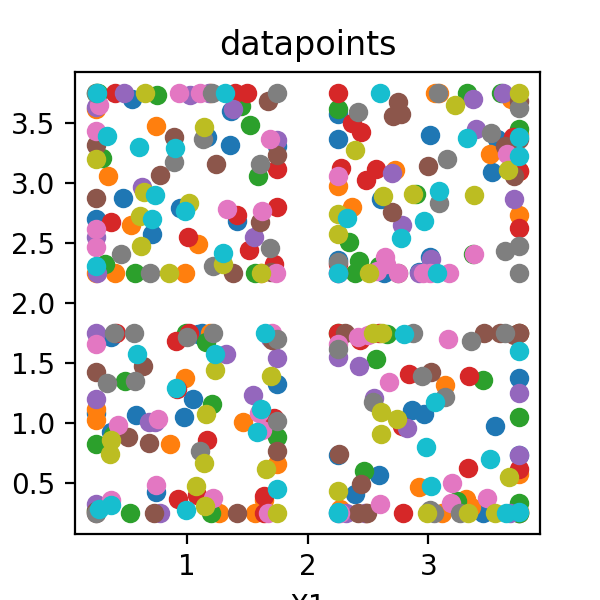

<IPython.core.display.Javascript object>


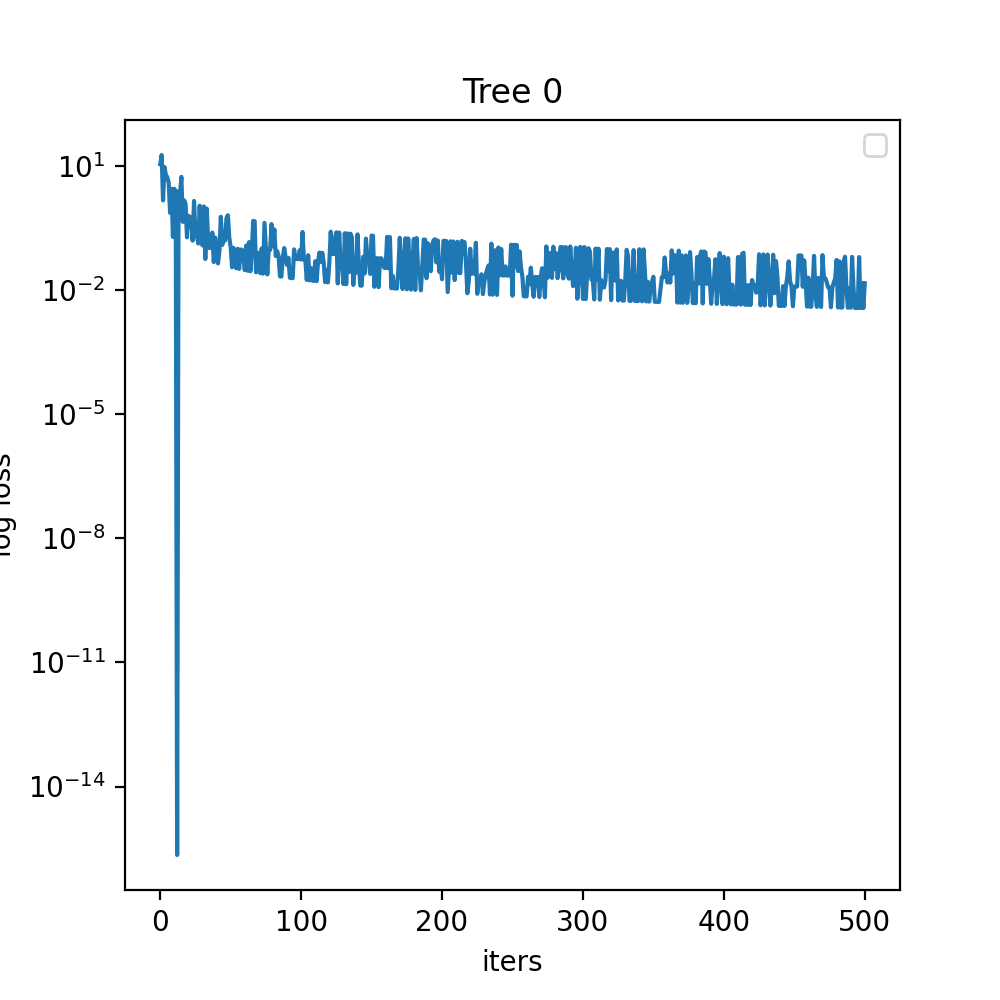

In [21]:
X, y, X_test, y_test, _X, _y = get_test_non_param_data()

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
for item in range(len(X)):
    ax.scatter(X[item, :, 0], X[item, :, 1])
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('datapoints')
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for item in range(len(X)):
    ax.scatter(X[item, :, 0], X[item, :, 1], c=y[item])
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('labels')
plt.savefig('non_param_datapoints.pdf')
plt.show()




In [40]:
from sklearn import tree
from sklearn.metrics import log_loss
from copy import deepcopy


def MSE(y_true, y_pred):
    logloss = log_loss(y_true, y_pred, labels=[0, 1])
    return logloss

def custom_log_loss(y_true, y_pred, lambda_value):
    logloss = log_loss(y_true, y_pred, labels=[0, 1])
    return lambda_value * (logloss)

def non_param_algorithm(X, X_test, y, y_test, _X, _y, K, subset_size, alpha):
    N = X.shape[0]
    nodes = [i for i in range(N)]
    w_hat = [tree.DecisionTreeClassifier(max_depth=2) for _ in range(N)]
    loss_history = []
    
    loss = []
    for i in range(N):
        if i != 0:
            continue
        w_hat[i].fit(X[i], y[i])
        mse = MSE(y_test[i], w_hat[i].predict(X_test[i]))
        loss.append(mse)
    loss_history.append(np.mean(loss))
        
#     fig, axes = plt.subplots(1, 1, figsize=(3, 3))
#     for i in range(len(w_hat)):
#         if i != 0:
#             continue
#         ax.set_title("Tree {}".format(i))
#         plot_tree_partition(X_test[i], y_test[i], w_hat[i], ax=axes, eps=0.2)
    
    mse = 0
    rewards = []
    new_X = [X[i] for i in range(N)]
    new_y = [y[i] for i in range(N)]
    plot_data = [[], [], []]
    sample_weighs = [np.ones_like(new_y[i]) for i in range(N)]
    for k in range(K):
        loss = []
#         print(k, mse, rewards, len(new_X[0]))
        for i in range(N):
            if i != 0:
                continue
            selected_nodes = random.sample(nodes, subset_size+1)
#             selected_nodes += [j for j in range(max(i-20, 0),min(i+20, N))]
            random.shuffle(selected_nodes)
            while i in selected_nodes:
                selected_nodes.remove(i)
                
            selected_nodes = selected_nodes[:subset_size] 
            
            rewards = []
            _trees = []
            _Xs = []
            _ys = []
            _sample_weights = []
            for node in selected_nodes:
# #                 updated_loss = custom_loss(y_test[node], w_hat[i].predict(X_test[node]), alpha)
#                 updated_loss = custom_log_loss(y_test[node], w_hat[i].predict(X_test[node]), alpha)
#                 print(updated_loss)
                _X = np.concatenate([new_X[i], X_test[node]])
                _Xs.append(_X)
                _y = np.concatenate([w_hat[i].predict(new_X[i]), y_test[node]])
#                 _y = np.concatenate([new_y[i], y[node]])
                _ys.append(_y)
#                 sample_weight = np.concatenate([np.ones_like(new_y[i]), np.ones_like(y[node])])
                sample_weight = np.concatenate([sample_weighs[i], np.ones_like(y_test[node]) * alpha])
                _sample_weights.append(sample_weight)
                
                _tree = tree.DecisionTreeClassifier(max_depth=2)
                _tree.fit(_X, _y, sample_weight=sample_weight)
#                 _tree.fit(_X, _y)
                _trees.append(_tree)
                
                updated_loss = custom_log_loss(y_test[node], _tree.predict(X_test[node]), alpha)
                rewards.append(updated_loss)
                
            idx = np.argmin(rewards)
            current_loss = custom_log_loss(y_test[i], w_hat[i].predict(X_test[i]), alpha)
#             if current_loss >= rewards[idx]:
            if True:
#                 print(idx, current_loss, rewards[idx])
                best_tree = _trees[idx]
                new_X[i] = _Xs[idx]
                new_y[i] = _ys[idx]
                sample_weighs[i] = _sample_weights[idx]
#                 new_X[i] = X[i]
#                 new_y[i] = y[i]
#                 sample_weighs[i] = np.ones_like(y[i])
            

                w_hat[i] = deepcopy(best_tree)  
            
            if i == 0:
                if k % 10 == 0 or k < 20:
#                     print(k)
#                     fig, axes = plt.subplots(1, 1, figsize=(3, 3))
                    for _i in range(N):
                        if _i != 0:
                            continue
                        ax.set_title("Tree {}".format(_i))
                        plot_data[0].append(new_X[_i])
                        plot_data[1].append(new_y[_i])
                        plot_data[2].append(w_hat[_i])
                        #plot_tree_partition(new_X[_i], new_y[_i], w_hat[_i], ax=axes, eps=0.2)
            
            
#             mse = MSE(y_test[i], w_hat[i].predict(X_test[i]))
            mse = MSE(_y, w_hat[i].predict(_X))
            loss.append(mse)
        loss_history.append(np.mean(loss))
        
    return w_hat, loss_history, w_hat, plot_data

In [34]:
alpha = 0.7
print(len(X), len(X[0]), len(X_test[0]), alpha)

40 10 20 0.7


In [44]:
K = 3000
results = []
for i in range(4):
    print(i)
    _, algo_loss_history, w_hat, plot_data = non_param_algorithm(X, X_test, y, y_test, _X, _y, K, 20, alpha)
    results.append(algo_loss_history)
    break
    
results = np.array(results)
algo_loss_history = np.mean(results, axis=0)


0


In [27]:
# 30% test
plt.plot([i for i in range(len(algo_loss_history))], algo_loss_history)
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('log loss')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [12]:
%matplotlib notebook

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import time

# Example data
_x = plot_data[0]
_y = plot_data[1]
_w = plot_data[2]

# Create a figure and axis object
fig, ax = plt.subplots()

# Define the update function
def update(frame):
    X = _x[frame]
    y = _y[frame]
    tree = _w[frame]
    min_value=0
    max_value=6
    eps=0.25
    
    ax.clear()
    
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    

    Z = tree.predict(X_grid)
    Z = Z.reshape(X1.shape)
    faces = tree.apply(X_grid)
    faces = faces.reshape(X1.shape)
    border = ndimage.laplace(faces) != 0
    ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
    ax.scatter(X1[border], X2[border], marker='.', s=1)
    

    ax.scatter(X[:, 0], X[:, 1], c=colors[y])
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)
    ax.set_xticks(())
    ax.set_yticks(())
#     time.sleep(2)

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=len(_x), interval=100)

# Show the plot
plt.show()

<IPython.core.display.Javascript object>


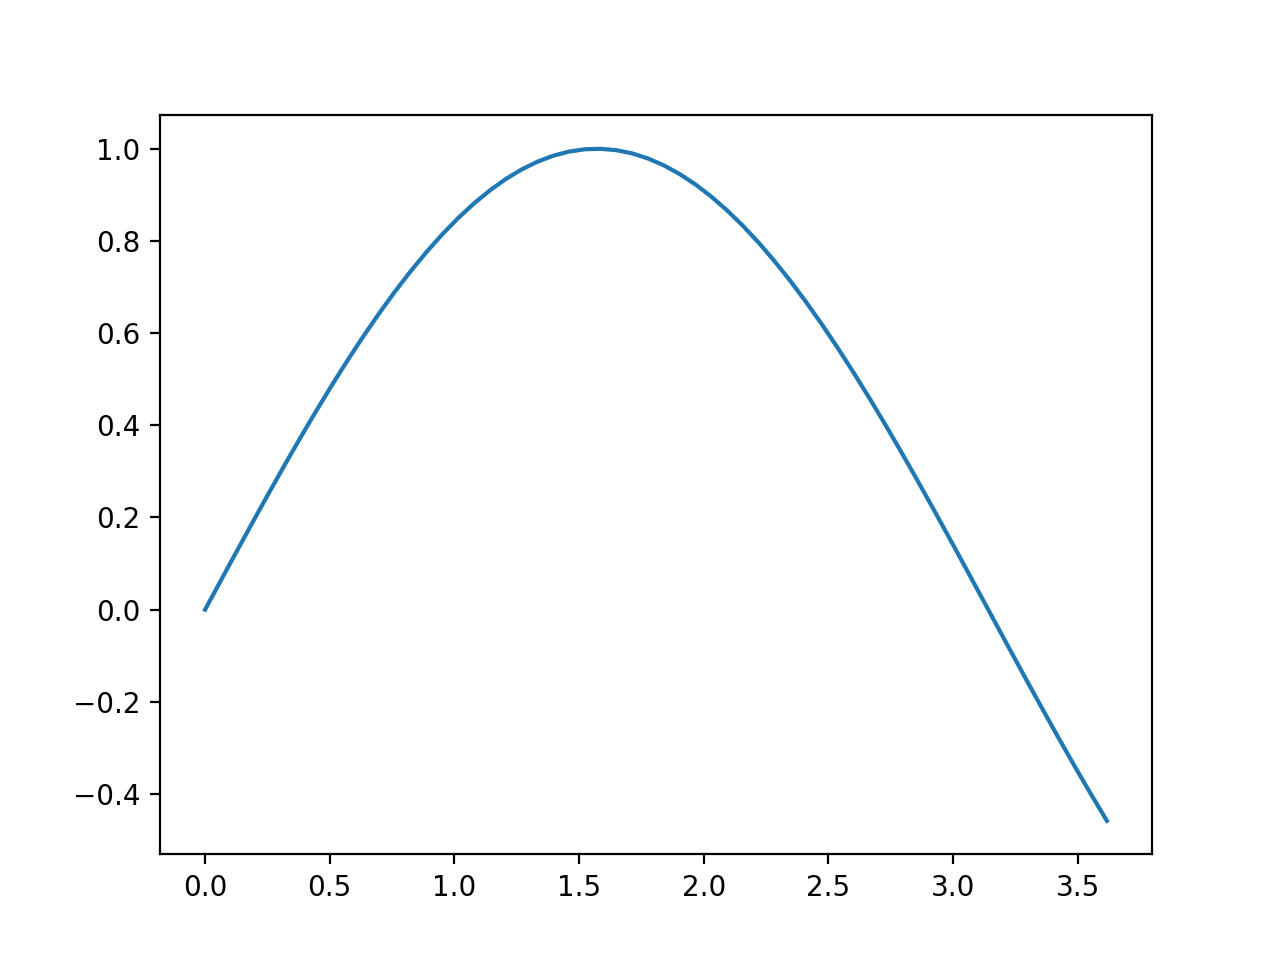

/Users/sarchey1/Homebrew/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Example data
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

# Create a figure and axis object
fig, ax = plt.subplots()

# Define the update function
def update(frame):
    ax.clear()
    ax.plot(x[:frame], y[:frame])

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=len(x), interval=100)

# Show the plot
plt.show()

In [319]:
x = [i for i in range(len(algo_loss_history))]
# print(len(loss_dm_algo[subset_sizes[0]][0]))
data = {'x': x}
data['y'] = algo_loss_history
    
df = pd.DataFrame.from_dict(data)

df.to_csv('clustered_FL_nonparam.csv', sep=',')

In [517]:
%matplotlib notebook

In [521]:

# import matplotlib.animation as animation

# fig, ax = plt.subplots()
# t = np.linspace(0, 3, 40)
# g = -9.81
# v0 = 12
# z = g * t**2 / 2 + v0 * t

# v02 = 5
# z2 = g * t**2 / 2 + v02 * t

# scat = ax.scatter(t[0], z[0], c="b", s=5, label=f'v0 = {v0} m/s')
# line2 = ax.plot(t[0], z2[0], label=f'v0 = {v02} m/s')[0]
# ax.set(xlim=[0, 3], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
# ax.legend()


# def update(frame):
#     # for each frame, update the data stored on each artist.
#     x = t[:frame]
#     y = z[:frame]
#     # update the scatter plot:
#     data = np.stack([x, y]).T
#     scat.set_offsets(data)
#     # update the line plot:
#     line2.set_xdata(t[:frame])
#     line2.set_ydata(z2[:frame])
#     return (scat, line2)


# ani = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
# plt.show()

In [545]:
w_hat[0].predict(X[0])

array([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1])

<IPython.core.display.Javascript object>


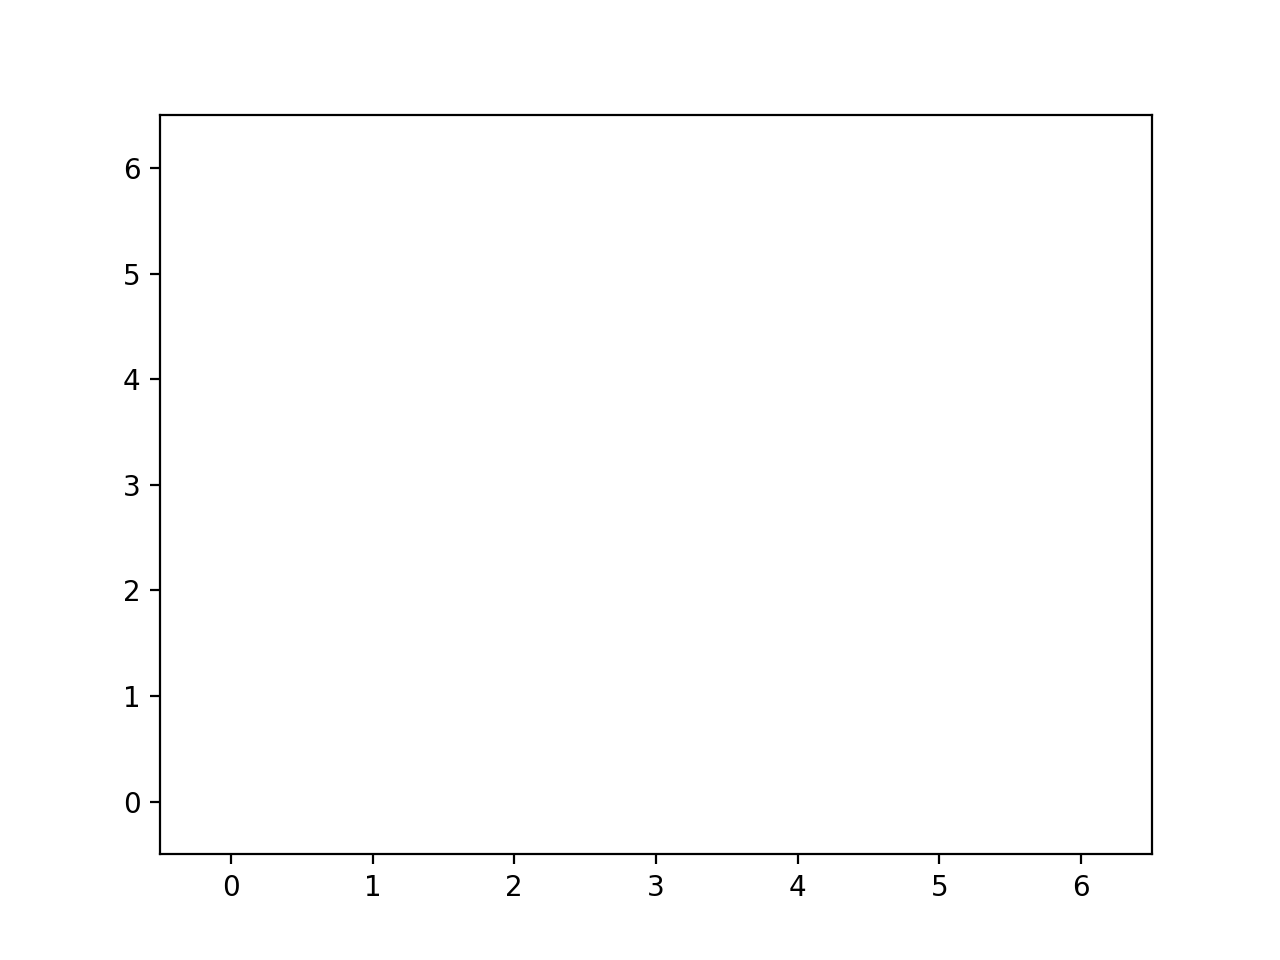

UnboundLocalError: local variable 'idx' referenced before assignment

In [550]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

# Create a random dataset for demonstration
_X, _y = X[0], y[0]

# Create a decision tree model
tree = DecisionTreeClassifier()

# Fit the model
tree.fit(_X, _y)

# Create a figure and axis for plotting
fig, ax = plt.subplots()

# Set the limits of the plot
ax.set_xlim(0 - 0.5, 6 + 0.5)
ax.set_ylim(0 - 0.5, 6 + 0.5)

# Create a scatter plot of the data points
# print(_X[:, 0], _X[:, 1], colors(np.array(_y)))
# scat = ax.scatter(_X[:, 0], _X[:, 1], c=colors[_y])
scat = ax.scatter([], [])

idx = 0
# Function to update the scatter plot
def update(frame):
    print(frame.shape, idx, tree)
    Z = w_hat[idx].predict(frame)
    idx += 1
#     Z = Z.reshape(xx.shape)
    scat.set_offsets(frame)
    print(Z)
    scat.set_array(Z)
    return scat,

# Create an animation
# ani = animation.FuncAnimation(fig, update, frames=X, interval=100, blit=True)
update(X)

# plt.show()

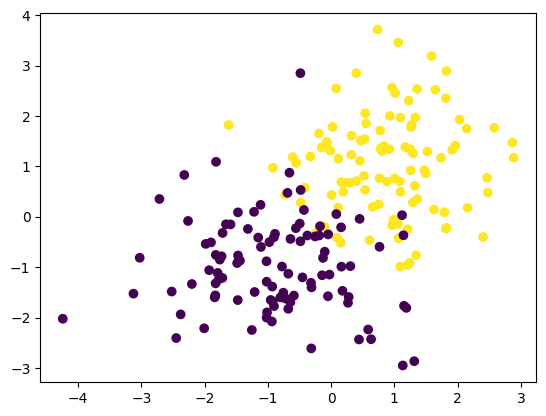

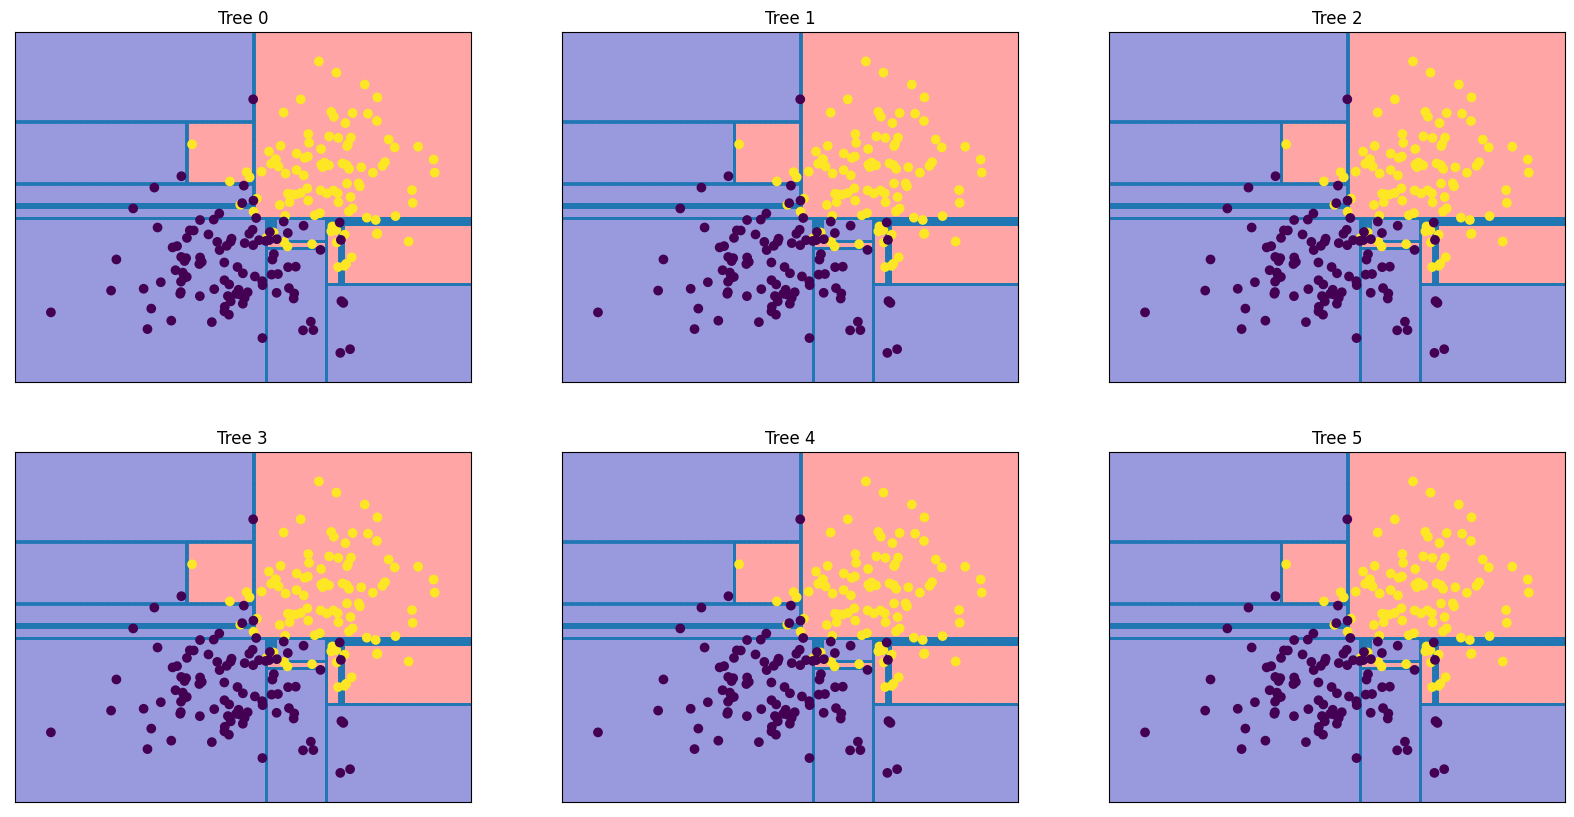

In [390]:
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree


n = 100
np.random.seed(42)
x = np.concatenate([np.random.randn(n, 2) + 1, np.random.randn(n, 2) - 1])
y = [1] * n + [0] * n
plt.scatter(x[:, 0], x[:, 1], c=y)

dtc = DecisionTreeClassifier().fit(x, y)
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    ax.set_title("Tree {}".format(i))
    plot_tree_partition(x, y, dtc, ax=ax)
#     ax.scatter(x[:, 0], x[:, 1], c=y)
    

### RandomForestRegressor

In [58]:
from sklearn.ensemble import RandomForestRegressor
from copy import deepcopy


def MSE(y_true, y_pred):
    m = len(y)
    loss = (1 / m) * np.sum((y_pred - y_true) ** 2)
    return loss

def custom_loss(y_true, y_pred, lambda_value):
#     loss = np.mean(np.square(y_true - y_pred))  # Squared Euclidean distance
    loss = MSE(y_true, y_pred)
#     regularization_term = lambda_value * some_regularization_function(tree)  # Adjust as needed
    regularization_term = 0
    return loss + regularization_term

def non_param_algorithm(X, X_test, y, w, clusters, K, subset_size, alpha):
    N = X.shape[0]
    nodes = [i for i in range(N)]
    w_hat = [RandomForestRegressor() for _ in range(N)]
    loss_history = []
    
    for i in range(N):
        w_hat[i].fit(X[i], y[i])
    
    mse = 0
    rewards = []
    new_X = [X[i] for i in range(N)]
    new_y = [y[i] for i in range(N)]
    for k in range(K):
        loss = []
#         print(k, mse, rewards, len(new_X[0]))
        for i in range(N):
            if i != 0:
                continue
            selected_nodes = random.sample(nodes, subset_size+1)
            if i in selected_nodes:
                selected_nodes.remove(i)
            selected_nodes = selected_nodes[:subset_size] 
            
            rewards = []
            _trees = []
            _Xs = []
            _ys = []
            _sample_weights = []
            for node in selected_nodes:
                updated_loss = custom_loss(y[node], w_hat[i].predict(X[node]), alpha)
                _X = np.concatenate([new_X[i], X[node]])
                _Xs.append(_X)
                _y = np.concatenate([w_hat[i].predict(new_X[i]), y[node]])
                _ys.append(_y)
                sample_weight = np.concatenate([np.ones_like(new_y[i]), np.ones_like(y[node]) * updated_loss])
                
                _tree = RandomForestRegressor()
                _tree.fit(_X, _y, sample_weight=sample_weight)
                _trees.append(_tree)
                # losses instead of rewards
                rewards.append(updated_loss)
#                 rewards.append(MSE(y[i], _tree.predict(X[i])))
                
            idx = np.argmin(rewards)
            best_tree = _trees[idx]
            new_X[i] = _Xs[idx]
            new_y[i] = _ys[idx]
            

            w_hat[i] = deepcopy(best_tree)   
            
            mse = MSE(y[i], w_hat[i].predict(X[i]))
            loss.append(mse)
        loss_history.append(np.mean(loss))
            
    return w_hat, loss_history

In [60]:
K = 200
K = 50
d_over_m = [0.2, 1, 2.5, 5, 10]
# d_over_m = [0.2]
loss_dm_algo=[]
for i in range(len(d_over_m)):  
    print(i)
    num_features = int(NUM_SAMPLES * d_over_m[i])
    X, y, w, clusters, X_test = get_data(num_features=num_features, noise=0.0, num_clients=50)
    _, algo_loss_history = non_param_algorithm(X, X_test, y, w, clusters, K, 20, alpha)
    loss_dm_algo.append(algo_loss_history)

0
1
2
3
4


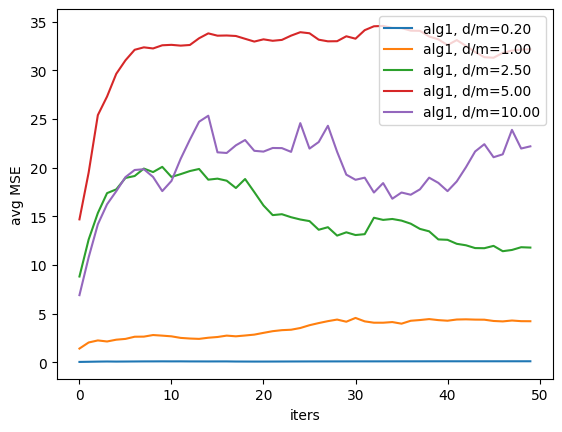

In [61]:
for item in range(len(loss_dm_algo)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
# plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

In [62]:
K = 200
d_over_m = [0.2, 1, 2.5, 5, 10]
loss_dm_algo=[]
for i in range(len(d_over_m)):  
    print(i)
    num_features = int(NUM_SAMPLES * d_over_m[i])
    X, y, w, clusters, X_test = get_data(num_features=num_features, noise=0.0, num_clients=50)
    _, algo_loss_history = non_param_algorithm(X, X_test, y, w, clusters, K, 20, alpha)
    loss_dm_algo.append(algo_loss_history)

0
1
2
3
4


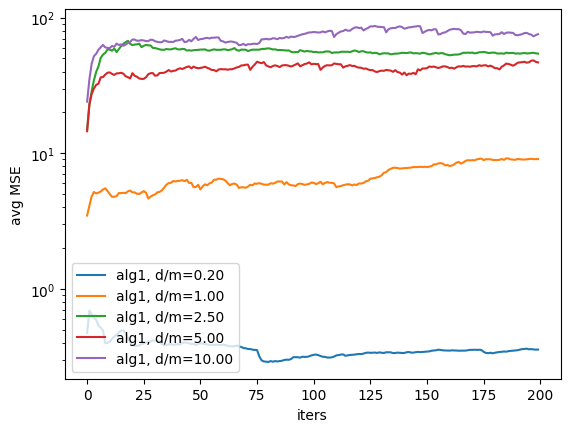

In [64]:
for item in range(len(loss_dm_algo)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

In [66]:
K = 200
d_over_m = [0.2, 1, 2.5, 5, 10]
loss_dm_algo=[]
for i in range(len(d_over_m)): 
    print(i)
    num_features = int(NUM_SAMPLES * d_over_m[i])
    X, y, w, clusters, X_test = get_data(num_features=num_features, noise=0.5, num_clients=50)
    _, algo_loss_history = non_param_algorithm(X, X_test, y, w, clusters, K, 20, alpha)
    loss_dm_algo.append(algo_loss_history)

0
1
2
3
4


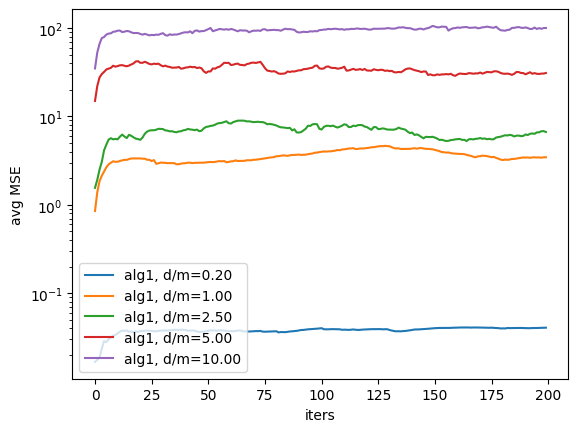

In [67]:
for item in range(len(d_over_m)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % d_over_m[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

## Sin data

In [95]:
def get_data(num_clients=NUM_CLIENTS, num_training_samples=NUM_SAMPLES, noise=0.0):    
    # Generate random intervals for each node
    interval_width = (10 - (-10)) / num_clients

    # Generate the intervals
    intervals = [(i * interval_width-10, (i + 1) * interval_width-10) for i in range(num_clients)]

    # Generate data for each node
    X = np.zeros((num_clients,num_training_samples, 1)) 
    y = np.zeros ((num_clients,num_training_samples))
    for i, (start, end) in enumerate(intervals):
        x = np.linspace(start, end, num_training_samples)
        X[i] = x.reshape(-1, 1)
        y[i] = np.sin(x) + np.random.normal(0, noise)
    
    
    return X, y


In [96]:
X, y = get_data(num_clients=20)

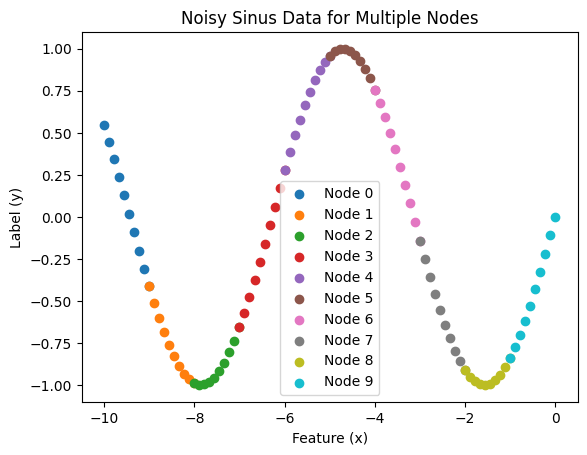

In [97]:
for i, (start, end) in enumerate(intervals):
    plt.scatter(X[i], y[i], label=f'Node {i}')
#     plt.plot(node_data['x'], np.sin(node_data['x']), linestyle='--', color='gray')  # True sinus function
plt.xlabel('Feature (x)')
plt.ylabel('Label (y)')
plt.title('Noisy Sinus Data for Multiple Nodes')
plt.legend()
plt.show()

In [131]:
from sklearn.tree import DecisionTreeRegressor
from copy import deepcopy


def MSE(y_true, y_pred):
    m = len(y)
    loss = (1 / m) * np.sum((y_pred - y_true) ** 2)
    return loss

def custom_loss(y_true, y_pred, lambda_value):
#     loss = np.mean(np.square(y_true - y_pred))  # Squared Euclidean distance
    loss = MSE(y_true, y_pred)
#     regularization_term = lambda_value * some_regularization_function(tree)  # Adjust as needed
    regularization_term = 0
    return loss + regularization_term

def non_param_algorithm(X, X_test, y, w, clusters, K, subset_size, alpha):
    N = X.shape[0]
    nodes = [i for i in range(N)]
    w_hat = [DecisionTreeRegressor(max_depth=1) for _ in range(N)]
    loss_history = []
    
    for i in range(N):
        w_hat[i].fit(X[i], y[i])
    
    mse = 0
    rewards = []
    new_X = [X[i] for i in range(N)]
    new_y = [y[i] for i in range(N)]
    for k in range(K):
        loss = []
#         print(k, mse, rewards, len(new_X[0]))
        for i in range(N):
            if i != 0:
                continue
            selected_nodes = random.sample(nodes, subset_size+1)
            if i in selected_nodes:
                selected_nodes.remove(i)
            selected_nodes = selected_nodes[:subset_size] 
#             selected_nodes.append(i)
            
            rewards = []
            _trees = []
            _Xs = []
            _ys = []
            _sample_weights = []
            for node in selected_nodes:
                updated_loss = custom_loss(y[node], w_hat[i].predict(X[node]), alpha)
                _X = np.concatenate([new_X[i], X[node]])
                _Xs.append(_X)
                _y = np.concatenate([w_hat[i].predict(new_X[i]), y[node]])
                _ys.append(_y)
                sample_weight = np.concatenate([np.ones_like(new_y[i]), np.ones_like(y[node]) * updated_loss])
                
                _tree = DecisionTreeRegressor(max_depth=1)
                _tree.fit(_X, _y, sample_weight=sample_weight)
                _trees.append(_tree)
                # losses instead of rewards
                rewards.append(updated_loss)
#                 rewards.append(MSE(y[i], _tree.predict(X[i])))
                
            idx = np.argmin(rewards)
#             print(selected_nodes, rewards)
            best_tree = _trees[idx]
            new_X[i] = _Xs[idx]
            new_y[i] = _ys[idx]
            

            w_hat[i] = deepcopy(best_tree)   
            
            mse = MSE(y[i], w_hat[i].predict(X[i]))
            loss.append(mse)
        loss_history.append(np.mean(loss))
            
    return w_hat, loss_history

In [137]:
K = 500
num_clients = [5, 10, 20, 50]
loss_dm_algo=[]
for clients in num_clients:
    X, y = get_data(num_clients=clients)
    _, algo_loss_history = non_param_algorithm(X, None, y, None, clusters, K, clients//2, alpha)
    loss_dm_algo.append(algo_loss_history)

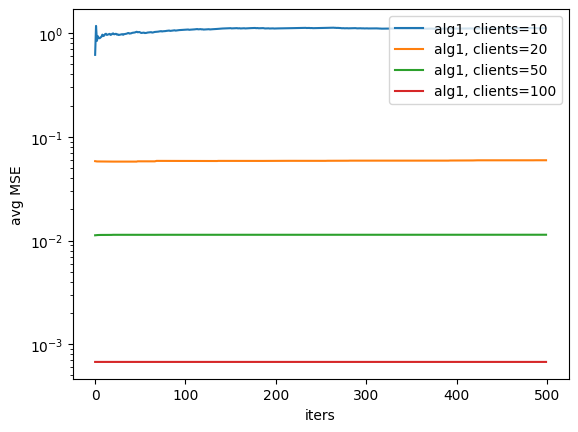

In [138]:
for item in range(len(loss_dm_algo)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, clients=%d' % num_samples[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()

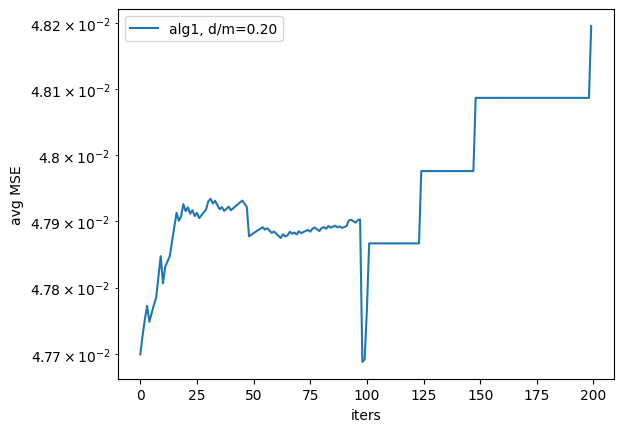

In [99]:
for item in range(len(loss_dm_algo)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='alg1, d/m=%.2f' % num_samples[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()